# Unsupervised ASR (ASR-U) using synthetic data
Author: Liming Wang

Date: 08/23/2022

## Asymptotic ASR-U on various Markov graphs

### 0. Utilities

In [ ]:
%matplotlib inline
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
random.seed(42)
np.random.seed(42)
font = {'size': 15}
matplotlib.rc('font', **font)

def k2f(v, k):
    d = len(v)
    powk = k**np.arange(d)
    return sum(v*powk)
    
def f2k(f, k, d=None):
    if d is None:
        d = math.ceil(math.log(f, k))
    powk = k**np.arange(d)
    return (f // powk) % k

def find_hamilton_cycle(A):
    n = A.shape[0]
    s = [([0], [])]
    while len(s):
        V, E = s.pop(-1)
        u = V[-1]
        for v in range(n):
            if (not v in V) and A[u, v]:
                new_V = V+[v]
                new_E = E+[(u, v)]              
                if len(new_V) == n and A[v, 0]:
                    new_E.append((v, 0))
                    return new_V, new_E
                s.append((new_V, new_E))
    print("No Hamilton cycle is found!")
    return [], []

def make_cycle(n, w=0.5):
    A = np.zeros((n, n))
    for i in range(n):
        A[i, (i+1)%n] = w
        A[(i+1)%n, i] = 1-w
    return A

def make_hypercube(n, weights=None):
    # Reference: https://blogs.mathworks.com/cleve/2017/02/20/hypercubes-and-graphs/
    if n == 0:
        return np.zeros(1)
    m = 2**n
    A = np.zeros((m, m))
    for i in range(m):
        v = f2k(i, 2, n)
        for j in range(n):
            v[j] = (v[j]+1)%2
            k = k2f(v, 2)
            A[i, k] = 1
            v[j] = (v[j]+1)%2
    
    if weights is not None:
        assert n > 1
        A = make_hypercube(n)
        V, E = find_hamilton_cycle(A)
        assert (len(E) == m) and (len(set(V)) == m)
        for i in range(m):
            for j in range(m):
                if (i, j) in E:
                    A[i, j] = weights[0]
                else:
                    A[i, j] = weights[1]
    return A

def make_debruijn(n, k, weights=None):
    if n == 0:
        return np.zeros(1)
    if weights is None:
        weights = [1]*k
    m = k**n
    A = np.zeros((m, m))
    for i in range(m):
        v = f2k(i, k, n)
        for l in range(k):
            w = np.append(v[1:], [l])
            j = k2f(w, k)
            A[i, j] = weights[(l-v[0])%k]
    return A

def make_erdos_renyi(n, p=0.5):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            A[i, j] = int(random.random() <= p)
            A[j, i] = A[i, j]
    return A

def make_communities(n, P):
    m = P.shape[0]
    size = n // m
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            ki = i // size
            kj = j // size
            if ki < m and kj < m:
              A[i, j] = int(random.random() <= P[ki, kj])
              A[j, i] = A[i, j]
            else:
              A[i, i] = 1.0
    return A

def make_circulant(n, S, ws=None):
    if ws is None:
        ws = [1]*len(S)
    A = np.zeros((n, n))
    for i in range(n):
        for k, w in zip(S, ws):
            A[i, (i+k)%n] = w
            # A[(i+k)%n, i] = w
    return A

def make_band_limited(n, band):
    bw = len(band)
    A = np.zeros((n, n))
    for i in range(n):
      for k, w in enumerate(band):
        if i+k < n:
          A[i, i+k] = w
          A[i+k, i] = w
    return A

def make_chain(n, w=0.5):
    A = np.zeros((n, n))
    for i in range(n-1):
        A[i, (i+1)%n] = w
        A[(i+1)%n, i] = 1-w
    return A

def make_disjoint_union(
        n, 
        sizes, 
        graph_type,
        return_eigvs=False,
    ):
    if isinstance(sizes, int):
        sizes = [sizes]*n
    else:
        assert len(sizes) == n
    m = sum(sizes)  # Number of nodes
    A = np.zeros((m, m))
    start = 0
    for i in sizes:
        if graph_type == "cube":
            A_i = make_hypercube(int(math.log2(i)))
        elif graph_type == "cycle":
            A_i = make_cycle(i)
        elif graph_type == "debruijn":
            A_i = make_debruijn(int(math.log2(i)), 2)
            A_i = A_i + A_i.T
        A[start:start+i, start:start+i] = A_i
        start += i
    if return_eigvs:
        eigvs = sorted(
            np.round(
                np.linalg.eigvals(A), 4
            )
        )
        return A, eigvs
    return A

def plot_graph(
        A, 
        titles=[
            'Adjacency matrix of the graph', 
            'Spectrum of the graph'
        ],
    ):
    plt.subplots_adjust(bottom=0.2)
    cmap = plt.cm.Greys
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    im0 = ax[0].imshow(A, cmap=cmap)
    ax[0].set_title(titles[0])
    fig.colorbar(im0, ax=ax[0], )

    # Compute the spectrum of the graph
    w = np.sort(np.round(np.linalg.eigvals(A), 8))
    im1 = ax[1].hist(
        w, 
        bins=np.linspace(w.min()-0.01, w.max()+0.01, 40), 
        rwidth=0.5,
    )
    ax[1].set_title(titles[1])

def plot_eigengap(A, precision=8):
    w = np.sort(
        np.round(
            np.linalg.eigvals(A), 
            precision,
        )
    )
    gaps = w[1:] - w[:-1]
    plt.subplots_adjust(bottom=0.2)
    fig, ax = plt.subplots()
    ax.hist(
        gaps,
        bins=np.linspace(0.0, gaps[:-1].max()+0.01, 40),
        rwidth=0.5,
    )
    ax.set_xlabel("Eigenvalue gaps (excluding the max eigenvalue)")
    ax.set_ylabel("Frequency")
    ax.grid()

def make_initial_prob(n):
    p_0 = np.random.uniform(0, 1, size=(n,))
    p_0 /= p_0.sum()
    return p_0

def make_initial_prob_zipf(n, a):
    p_0 = np.asarray(
        [1./(i**a) for i in range(1, n+1)]
    )
    p_0 /= p_0.sum()
    return p_0

def make_asr(n_x, n_y):
    O = np.zeros((n_x, n_y))
    for i in range(n_x):
        j = np.random.randint(n_y)
        O[i, j] = 1
    return O

def make_selection_matrices(n, l, ngram_steps):
    if ngram_steps is None:
        ngram_steps = range(n)
    m = n**l
    E = np.zeros((l, m, n))
    for j in ngram_steps:
        block_len = n**(j+1)
        block_num = m // block_len
        sub_len = n**j
        for k in range(block_num):
            for i in range(n):
                E[j, k*block_len+i*sub_len:k*block_len+(i+1)*sub_len, i] = 1
    return E

def make_asr_u_matrices(p_0, T, O, l, n, ngram_steps=None):
    n_x, n_y = O.shape 
    m = n_x**n
    assert p_0.shape[0] == T.shape[0] == T.shape[1] == m 
    P_X = np.zeros((l, m))
    P_Y = np.zeros((l, n_y))
    P_X[0] = p_0
    for t in range(1, l):
        P_X[t] = P_X[t-1] @ T

    Es = make_selection_matrices(n_x, n, ngram_steps=ngram_steps)
    P_X = np.concatenate(
        [P_X @ E for E in Es]
    )
    P_Y = P_X @ O
    return P_X, P_Y

def exact_asr_u(P_X, P_Y):
    return np.linalg.pinv(P_X) @ P_Y

def calc_per(O_pred, O_true):
    return (O_pred.argmax(-1) != O_true.argmax(-1)).mean()

### 1. Disjoint union of cycles
The eigenvalues of the adjacency matrix of the cycle $C_n$ are $-\cos(\frac{2\pi k}{n}), k=0,\cdots,\lfloor \frac{n-1}{2}\rfloor+1$. Therefore, we can create a Markov graph with $m$ nodes and at most $n$ eigenvalues by a disjoint union of $\lfloor\frac{m}{2n-1}\rfloor$ $C_{2n-1}$ cycles, with the rest of the nodes being self-loops. 

#### 1.1 Visualize the adjacency matrix and the spectrum of a disjoint union of cycles

Acoustic feature codebook size: 10
N-gram size: 2
Eigenvalues according to theory:  [ 1.          0.96291729  0.8544194   0.68255314  0.46006504  0.20345601
 -0.06824241 -0.33487961 -0.57668032 -0.77571129 -0.9172113  -0.99068595]


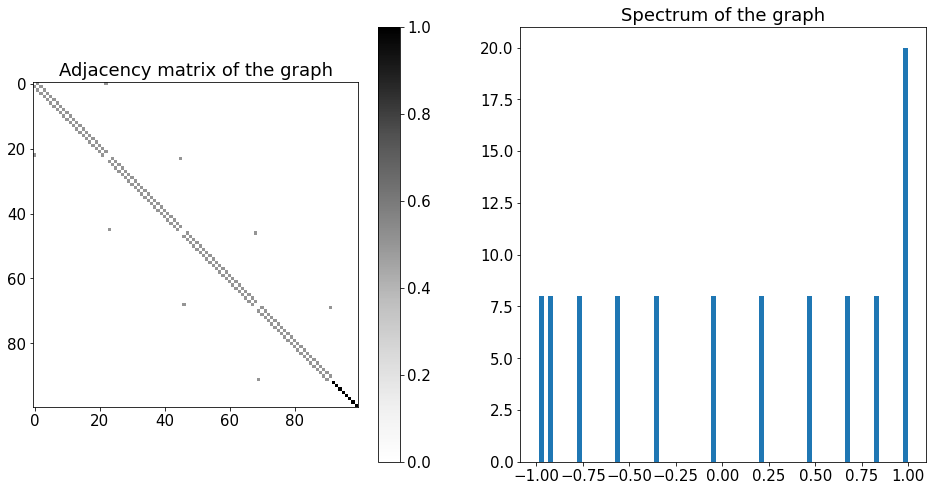

In [ ]:
# Create a union of cycles
n_x = 10  # codebook size of the acoustic features
n = 2  # n-gram size
print(
    f"Acoustic feature codebook size: {n_x}\n"
    f"N-gram size: {n}" 
)
m = n_x**n  # number of n-grams
n_eigv = 12  # maximum number of eigenvalues

n_cycles = m // (2 * n_eigv - 1)
m_r = n_cycles * (2 * n_eigv - 1)
n_parts = n_cycles + m - m_r
sizes = [2 * n_eigv - 1 for i in range(n_cycles)]
sizes += [1]*(m-m_r)
A = make_disjoint_union(n_parts, sizes, "cycle")
Di = np.diag(1./A.sum(-1))
T = Di @ A

# Plot the graph adjacency matrix and the spectrum of the transition matrix
plot_graph(T)
w_0 = 2*math.pi/(2*n_eigv-1)
print('Eigenvalues according to theory: ', np.cos(w_0*np.arange(n_eigv)))

#### 1.2 Exact solution for ASR-U on a disjoint union of cycles

In [ ]:
n_y = 5  # Vocabulary size of the text
l = 10 # Utterance length

# Create matrices used in ASR-U
p_0 = make_initial_prob(n_x**n)
O_true = make_asr(n_x, n_y) 
P_X, P_Y = make_asr_u_matrices(
    p_0, T, O_true, l, n,
)

# Least-square solution of the matrix equation
O_pred = exact_asr_u(P_X, P_Y)
per = calc_per(O_pred, O_true)
print(f"Phone error rate (PER): {per:.3f}")

Phone error rate (PER): 0.000


#### 1.3 PER vs number of distinct, nonzero eigenvalues in $T$

          Codebook size  Number of distinct nonzero eigenvalues in $T$  PER
0    $|\mathcal{X}|=$10                                              2  0.8
1    $|\mathcal{X}|=$10                                              3  0.5
2    $|\mathcal{X}|=$10                                              4  0.4
3    $|\mathcal{X}|=$10                                              5  0.1
4    $|\mathcal{X}|=$10                                              6  0.0
..                  ...                                            ...  ...
445  $|\mathcal{X}|=$14                                             15  0.0
446  $|\mathcal{X}|=$14                                             16  0.0
447  $|\mathcal{X}|=$14                                             17  0.0
448  $|\mathcal{X}|=$14                                             18  0.0
449  $|\mathcal{X}|=$14                                             19  0.0

[450 rows x 3 columns]


KeyboardInterrupt: ignored

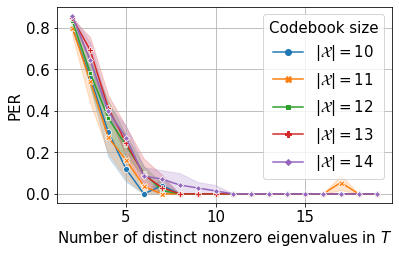

In [ ]:
random.seed(0)
np.random.seed(0)
n_trials = 5
n = 2  # n-gram size
n_y = 10  # Vocabulary size of the text
l = 20 # Utterance length
data_dict = {
    "Codebook size": [],
    r"Number of distinct nonzero eigenvalues in $T$": [],
    "PER": [],
}
for _ in range(n_trials):
    for n_x in range(10, 15):
        n_eigv_list = list(range(2, 20)) 
    
        for i, n_eigv in enumerate(n_eigv_list):
            # Create a union of cycles
            m = n_x**n  # number of n-grams
            n_cycles = m // (2 * n_eigv - 1)
            m_r = n_cycles * (2 * n_eigv - 1)
            n_parts = n_cycles + m - m_r
            sizes = [2 * n_eigv - 1 for i in range(n_cycles)]
            sizes += [1]*(m-m_r)
            A = make_disjoint_union(n_parts, sizes, "cycle")
            Di = np.diag(1./A.sum(-1))
            T = Di @ A

            # Create matrices used in ASR-U
            p_0 = make_initial_prob(n_x**n)
            O_true = np.eye(n_x)[np.random.permutation(n_x)] # make_asr(n_x, n_y) 
            P_X, P_Y = make_asr_u_matrices(
                p_0, T, O_true, l, n, ngram_steps=[0],
            )

            # Least-square solution of the matrix equation
            O_pred = exact_asr_u(P_X, P_Y)
            data_dict[r"Codebook size"].append(r"$|\mathcal{X}|=$"+str(n_x))
            data_dict[r"Number of distinct nonzero eigenvalues in $T$"].append(n_eigv)
            data_dict["PER"].append(
                calc_per(O_pred, O_true)
            )

# Plot PER vs num. of eigenvalues using seaborn
df = pd.DataFrame(data_dict)
print(df)
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)
sns.lineplot(
    data=df,
    x=r"Number of distinct nonzero eigenvalues in $T$",
    y="PER",
    hue="Codebook size",
    style="Codebook size",
    markers=True,
    dashes=False,
)
plt.grid()
#plt.title(r"ASR-U PER vs. num. of eigenvalues in $T$")
plt.savefig("asymp_disjoint_cycles")

### 2. Disjoint union of $n$-cubes
An $n$-cube $Q_n$ is a graph with $2^n$ nodes such that node $i$ connects to any node $j$ with Hamming distance between their binary numerals $d_{H}(b(i), b(j))=1$. The eigenvalues of the adjacency matrix of $Q_n$ is $1-\frac{2k}{n},k=0,\cdots,n$. Therefore, we can create a Markov graph with $m$ nodes and $n\leq \lfloor\log_2 m\rfloor$ eigenvalues by a disjoint union of $\lfloor\frac{m}{2^n}\rfloor$ $n$-cubes, with the rest of the nodes being self-loops. 



#### 2.1 Visualize the adjacency matrix and the spectrum of a disjoint union of $n$-cubes

Eigenvalues according to theory:  [ 1.          0.77777778  0.55555556  0.33333333  0.11111111 -0.11111111
 -0.33333333 -0.55555556 -0.77777778 -1.        ]


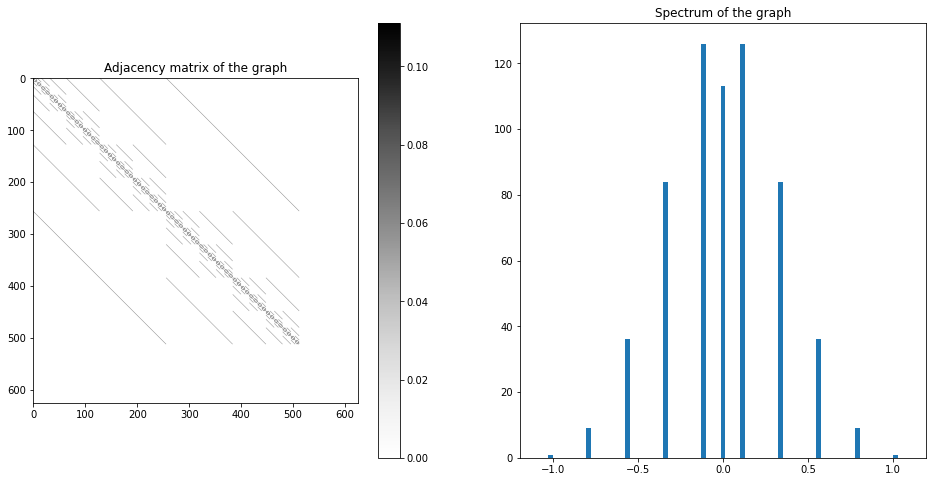

In [ ]:
# Create a disjoint union of n-cubes
n_x = 5  # codebook size of the acoustic features
n = 4  # n-gram size
m = n_x**n
n_eigv = 9  # number of eigenvalues
n_cubes = m // 2**n_eigv
m_r = n_cubes * 2**n_eigv
n_parts = n_cubes + m - m_r
sizes = [2**n_eigv]*n_cubes
sizes += [1]*(m-m_r)
A = make_disjoint_union(n_parts, sizes, "cube")
Di = np.diag(1./(A.sum(-1)+1e-10))
T = Di @ A

# Plot the graph adjacency matrix and the spectrum of the transition matrix
plot_graph(T)
print('Eigenvalues according to theory: ', 1-2*np.arange(n_eigv+1)/n_eigv)

#### 2.2 PER vs number of distinct, nonzero eigenvalues in $T$

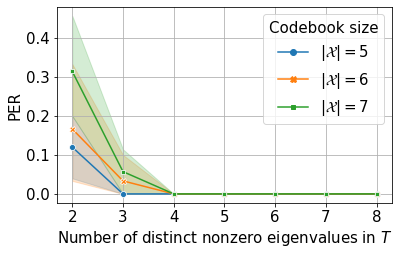

In [ ]:
random.seed(0)
np.random.seed(0)
n_trials = 5
n = 4  # n-gram size
n_y = 5  # Vocabulary size of the text
l = 10 # Utterance length
data_dict = {
    "Codebook size": [],
    r"Number of distinct nonzero eigenvalues in $T$": [],
    "PER": [],
}
for _ in range(n_trials):
    for n_x in range(5, 8):
        m = n_x**n  # number of n-grams
        n_eigv_list = list(range(2, 9)) 
        for i, n_eigv in enumerate(n_eigv_list):
            # Create a union of n-cubes
            n_cubes = m // 2**n_eigv
            m_r = n_cubes * 2**n_eigv
            n_parts = n_cubes + m - m_r
            sizes = [2**n_eigv]*n_cubes
            sizes += [1]*(m-m_r)
            A = make_disjoint_union(n_parts, sizes, "cycle")
            Di = np.diag(1./(A.sum(-1)+1e-10))
            T = Di @ A

            # Create matrices used in ASR-U
            p_0 = make_initial_prob(n_x**n)
            O_true = make_asr(n_x, n_y) 
            P_X, P_Y = make_asr_u_matrices(
                p_0, T, O_true, l, n, ngram_steps=[0],
            )

            # Least-square solution of the matrix equation
            O_pred = exact_asr_u(P_X, P_Y)
            data_dict[r"Codebook size"].append(r"$|\mathcal{X}|=$"+str(n_x))
            data_dict[r"Number of distinct nonzero eigenvalues in $T$"].append(n_eigv)
            data_dict["PER"].append(
                calc_per(O_pred, O_true)
            )

# Plot PER vs num. of eigenvalues using seaborn
df = pd.DataFrame(data_dict)
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)
sns.lineplot(
    data=df,
    x=r"Number of distinct nonzero eigenvalues in $T$",
    y="PER",
    hue="Codebook size",
    style="Codebook size",
    markers=True,
    dashes=False,
)
plt.grid()
# plt.title(r"ASR-U PER vs. num. of distinct nonzero eigenvalues in $T$")
plt.savefig("asymp_hypercube")

###3. Disjoint union of undirected De Bruijn graph

A De Bruijn graph $DB(k, n)$ is a graph with $k^n$ nodes such that node $i$ connects to any node $j$ whose $k$-ary numerals $v(i)$ and $v(j)$ satisfies $v_{2:n}(i) = v_{1:n-1}(j)$. The eigenvalues of $DB(k, n)$ is $\cos\frac{i\pi}{j}, 0\leq i < j \leq n+1$ (Delorme and Tillich, 1998, https://core.ac.uk/download/pdf/82810454.pdf). Therefore, we can create a Markov graph with $m$ nodes and less than $n, n\leq(\lfloor\log_k m\rfloor + 1)^2/2$ distinct, nonzero eigenvalues by a disjoint union of $\lfloor\frac{m}{k^{\sqrt{2n}-1}}\rfloor$ $DB(k, \sqrt{2n}-1)$ graphs, with the rest of the nodes being self-loops.

####3.1 Visualize the adjacency matrix and the spectrum of an undirected De Bruijn graphs

Eigenvalues according to theory:  [-0.809, -0.707, -0.5, -0.309, 0.0, 0.309, 0.5, 0.707, 0.809, 1.0]


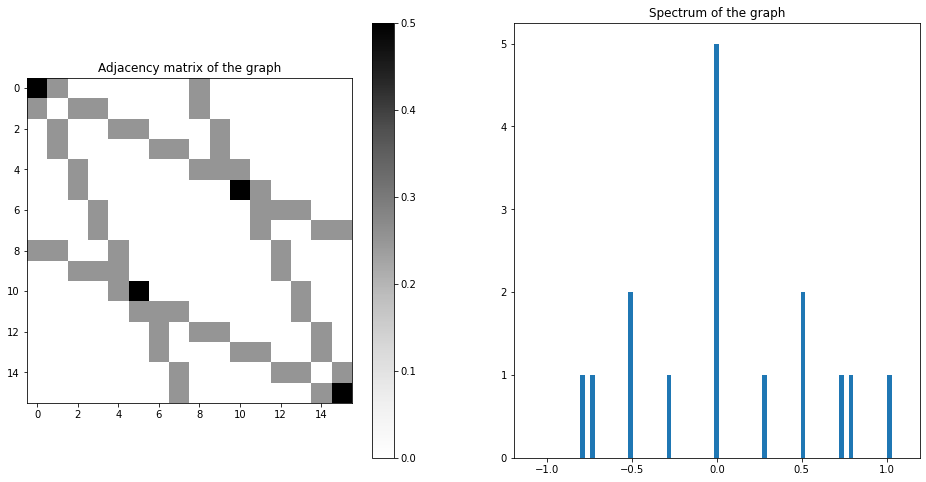

In [ ]:
# Create a De Bruijn graphs
k = 2  # codebook size of the acoustic features
n = 4  # n-gram size

A = make_debruijn(n, k)
A = A + A.T
Di = np.diag(1./(A.sum(-1)+1e-10))
T = Di @ A

# Plot the graph adjacency matrix and the spectrum of the transition matrix
plot_graph(T)
w_0 = math.pi
fs = np.asarray(
    [
        i/j 
        for i in range(n+2)\
        for j in range(i+1, n+2)
    ]
)
print(
    'Eigenvalues according to theory: ', 
    sorted(
        set(
            np.round(np.cos(w_0*fs), 3)
        )
    )
)

####3.2 Visualize the adjacency matrix and the spectrum of a disjoint union of undirected De Bruijn graphs

Acoustic feature codebook size: 8
N-gram size: 3
Number of distinct nonzero eigenvalues (upper bound): 50
DB sequence length: 9
Eigenvalues according to theory:  [-0.951, -0.94, -0.924, -0.901, -0.866, -0.809, -0.766, -0.707, -0.623, -0.588, -0.5, -0.383, -0.309, -0.223, -0.174, 0.0, 0.174, 0.223, 0.309, 0.383, 0.5, 0.588, 0.623, 0.707, 0.766, 0.809, 0.866, 0.901, 0.924, 0.94, 0.951, 1.0]


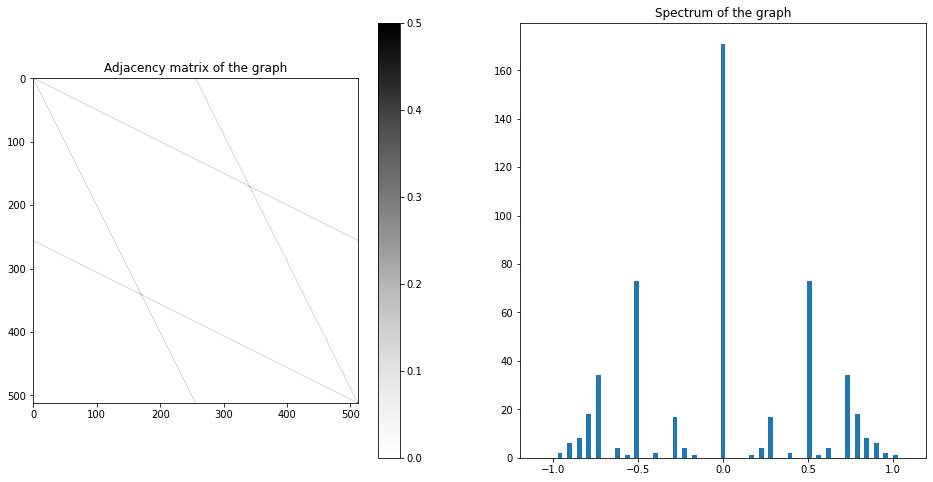

In [ ]:
# Create a disjoint union of n-cubes
n_x = 8  # codebook size of the acoustic features
n = 3  # n-gram size
m = n_x**n
n_eigv = 50  # maximal number of eigenvalues
d = 2  # degree of the DB graph
k = int(math.sqrt(2*n_eigv)-1)  # length of the DB sequence
print(
    f"Acoustic feature codebook size: {n_x}\n"
    f"N-gram size: {n}\n"
    f"Number of distinct nonzero eigenvalues (upper bound): {n_eigv}\n"
    f"DB sequence length: {k}"
)
n_db = m // (d**k)
m_r = n_db * d**k
n_parts = n_db + m - m_r
sizes = [d**k]*n_db
sizes += [1]*(m-m_r)
A = make_disjoint_union(n_parts, sizes, "debruijn")
Di = np.diag(1./(A.sum(-1)+1e-10))
T = Di @ A

# Plot the graph adjacency matrix and the spectrum of the transition matrix
plot_graph(T)
w_0 = math.pi
fs = np.asarray(
    [
        i/j 
        for i in range(k+2)\
        for j in range(i+1, k+2)
    ]
)
print(
    'Eigenvalues according to theory: ', 
    sorted(
        set(
            np.round(np.cos(w_0*fs), 3)
        )
    )
)

#### 3.3 PER vs number of distinct, nonzero eigenvalues in $T$

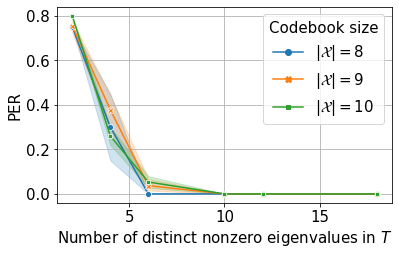

In [ ]:
random.seed(0)
np.random.seed(0)
n_trials = 5
n = 3  # n-gram size
l = 10 # Utterance length
d = 2  # degree of the DB graph
data_dict = {
    "Codebook size": [],
    r"Number of distinct nonzero eigenvalues in $T$": [],
    "PER": [],
}
for _ in range(n_trials):
    for n_x in range(8, 11):
        n_y = n_x  # Vocabulary size of the text
        m = n_x**n  # number of n-grams
        n_eigv_list = list(range(2, 32, 2)) 
        for i, n_eigv in enumerate(n_eigv_list):
            # Create a union of De Brujin graphs
            k = int(math.sqrt(2*n_eigv)-1)  # length of the DB sequence
            n_db = m // (d**k)
            m_r = n_db * d**k
            n_parts = n_db + m - m_r
            sizes = [d**k]*n_db
            sizes += [1]*(m-m_r)
            n_parts = n_db + m - m_r
            A, eigvs = make_disjoint_union(
                n_parts, 
                sizes, 
                "debruijn",
                return_eigvs=True,
            )
            Di = np.diag(1./(A.sum(-1)+1e-10))
            T = Di @ A

            # Create matrices used in ASR-U
            p_0 = make_initial_prob(n_x**n)
            O_true = np.eye(n_x)[np.random.permutation(n_x)]
            P_X, P_Y = make_asr_u_matrices(
                p_0, T, O_true, l, n, ngram_steps=[0],
            )

            # Least-square solution of the matrix equation
            O_pred = exact_asr_u(P_X, P_Y)
            data_dict[
                r"Codebook size"
            ].append(r"$|\mathcal{X}|=$"+str(n_x))
            data_dict[
                r"Number of distinct nonzero eigenvalues in $T$"
            ].append(len(set(eigvs)))
            data_dict["PER"].append(
                calc_per(O_pred, O_true)
            )

# Plot PER vs num. of eigenvalues using seaborn
df = pd.DataFrame(data_dict)
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)
sns.lineplot(
    data=df,
    x=r"Number of distinct nonzero eigenvalues in $T$",
    y="PER",
    hue="Codebook size",
    style="Codebook size",
    markers=True,
    dashes=False,
)
plt.grid()
# plt.title(r"ASR-U PER vs. num. of distinct nonzero eigenvalues in $T$")
plt.savefig("asymp_debruijn")

### 4. Erdos-Renyi random graph
An Erdos-Renyi random graph $ER(n, p)$ is created by connecting an edge between node $i$ and node $j$ with probability $p$ independently. Based on (Nguyen, Tao and Vu, 2017, https://arxiv.org/pdf/1504.00396.pdf), we can prove that for any $A > 0$, there exists some $B > 0$ such that with probability at least $1-n^{-B}$, the consecutive eigenvalue gaps of the Markov matrix for $ER(n, p)$ is at least $n^{-A}$. As a result, with high probability ASR-U is feasible for Markov chains on ER(n, p).

####4.1 Visualize the adjacency matrix and the spectrum of an $ER(n, p)$ graph

<Figure size 432x288 with 0 Axes>

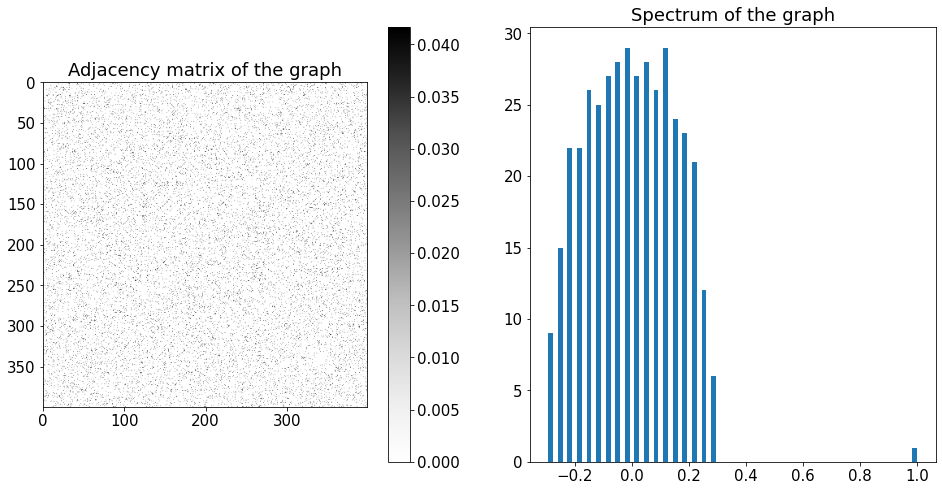

In [ ]:
n_x = 20  # codebook size of the acoustic features
n = 2  # n-gram size
m = n_x**n
A = make_erdos_renyi(m, 0.1)
Di = np.diag(1/(A.sum(-1)+1e-10))
T = Di @ A
plot_graph(T)

####4.2 Visualize the eigenvalue gap distribution of an $ER(n, p)$ graph

(0.0, 0.01)

<Figure size 432x288 with 0 Axes>

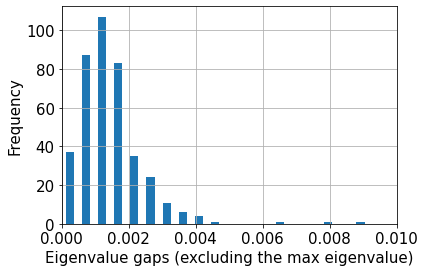

In [ ]:
plot_eigengap(T)
plt.xlim([0, 0.01])

####4.3 PER vs. number of nodes ($n$) and edge probability ($p$)

Text(0.5, 1.0, 'ASR-U PER vs. num. of distinct nonzero eigenvalues in $T$')

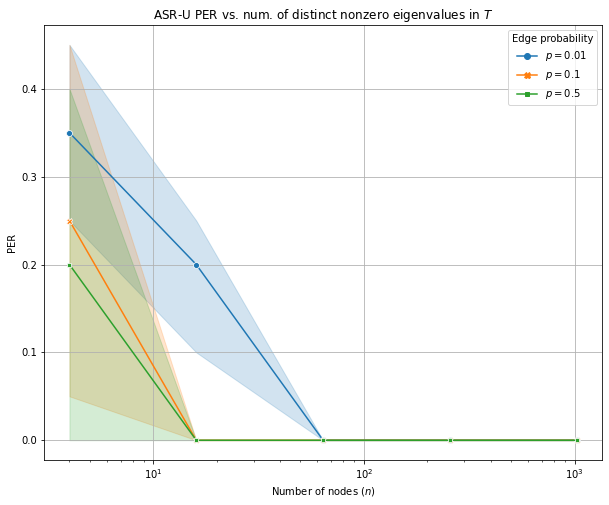

In [ ]:
n_trials = 5
n_x = 4  # Acoustic feature codebook size
n_y = 3  # Vocabulary size of the text
l = 10 # Utterance length
data_dict = {
    "Edge probability": [],
    r"Number of nodes ($n$)": [],
    "PER": [],
}
for _ in range(n_trials):
    for n in range(1, 6):
        m = n_x**n  # number of n-grams
        for p in [0.01, 0.1, 0.5]:
            A = make_erdos_renyi(m, p)
            Di = np.diag(1./(A.sum(-1)+1e-10))
            T = Di @ A

            # Create matrices used in ASR-U
            p_0 = make_initial_prob(m)
            O_true = make_asr(n_x, n_y) 
            P_X, P_Y = make_asr_u_matrices(
                p_0, T, O_true, l, n,
            )

            # Least-square solution of the matrix equation
            O_pred = exact_asr_u(P_X, P_Y)
            data_dict[
                "Edge probability"
            ].append(r"$p=$"+str(p))
            data_dict[
                r"Number of nodes ($n$)"
            ].append(m)
            data_dict["PER"].append(
                calc_per(O_pred, O_true)
            )

# Plot PER vs num. of eigenvalues using seaborn
df = pd.DataFrame(data_dict)
fig, ax = plt.subplots()
sns.lineplot(
    data=df,
    x=r"Number of nodes ($n$)",
    y="PER",
    hue="Edge probability",
    style="Edge probability",
    markers=True,
    dashes=False,
)
ax.set_xscale("log")
plt.grid()
plt.title(r"ASR-U PER vs. num. of distinct nonzero eigenvalues in $T$")

##    Finite-sample ASR-U on various Markov graphs

###0. Utilities

In [ ]:
from copy import deepcopy
from collections import defaultdict
from IPython.core.debugger import set_trace
import os
from pathlib import Path
import shutil


def draw(p):
    v = random.random()
    i = 0
    v -= p[0]
    while v > 0:
        i += 1
        v -= p[i]
    return i

def create_asr_u_dataset(
        p_0,  # Initial prob matrix
        T,  # Transition prob matrix
        O,  # Assignment (ASR) matrix 
        n_x,  # Acoustic feature codebook size
        n_y,  # Textual alphabet size
        n,  # n-gram (segment) size
        l,  # Sentence length
        N_x,  # Number of acoustic feature samples
        N_y,  # Number of text samples
    ):
    X, Y = [], []
    for _ in range(N_x):
        x_t_1 = np.random.choice(
            np.arange(n_x**n),
            p=p_0,
        )
        x = [f2k(x_t_1, n_x, n)]
        for t in range(l-1):
            x_t = np.random.choice(
                np.arange(n_x**n), 
                p=T[x_t_1],
            )
            x.append(
                f2k(x_t, n_x, n)
            )
            x_t_1 = deepcopy(x_t)
        X.append(x)
    X = np.asarray(X)
    
    y_indices = O.argmax(-1)
    for _ in range(N_y):
        x_t_1 = np.random.choice(
            np.arange(n_x**n),
            p=p_0,
        )
        y_t_1 = [
            y_indices[i] 
            for i in f2k(x_t_1, n_x, n)
        ]
        y = [y_t_1]
        for _ in range(l-1):
            x_t = np.random.choice(
                np.arange(n_x**n),
                p=T[x_t_1],
            )
            y_t = [
                y_indices[i] 
                for i in f2k(x_t, n_x, n)
            ]
            y.append(y_t)
            x_t_1 = deepcopy(x_t)
        Y.append(y)
    Y = np.asarray(Y)
    return X, Y

def create_matched_asr_u_dataset(
        p_0,  # Initial prob matrix
        T,  # Transition prob matrix
        O,  # Assignment (ASR) matrix 
        n_x,  # Acoustic feature codebook size
        n_y,  # Textual alphabet size
        n,  # n-gram (segment) size
        l,  # Sentence length
        N_x,  # Number of acoustic feature samples
        N_y,  # Number of text samples
    ):
    X, Y = [], []
    y_indices = O.argmax(-1)
    for _ in range(N_x):
        x_t_1 = np.random.choice(
            np.arange(n_x**n),
            p=p_0,
        )
        y_t_1 = [
            y_indices[i] 
            for i in f2k(x_t_1, n_x, n)
        ]
        x = [f2k(x_t_1, n_x, n)]
        y = [y_t_1]
        for t in range(l-1):
            x_t = np.random.choice(
                np.arange(n_x**n), 
                p=T[x_t_1],
            )
            y_t = [
                y_indices[i] 
                for i in f2k(x_t, n_x, n)
            ]
            x.append(
                f2k(x_t, n_x, n)
            )
            y.append(y_t)
            x_t_1 = deepcopy(x_t)
        X.append(x)
        Y.append(y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

def save_asr_u_dataset(X, Y, O, split_dict, save_dir, err_rate=None):
    """
    Dataset organization:
        [save_dir]/ 
            [split].tsv: first line contains the root path and
                each following line contains a path and the length
                of the utterance separated by tabs
            [split].wrd: 
                each line contains a word-level transcript
            [split].phn:
                each line contains a phoneme-level transcript
            dict.txt:
                each line contains [word type] [frequency]
                in decreasing order
            words.txt:
                each line contains a single word type
            phones.txt:
                each line contains a single phone
            [split].npy:
                2-D matrix by concatenating the features for
                different utterances
            [split].length:
                each line contains the length of feature for
                an utterance
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(
        parents=True, exist_ok=True
    )

    # Create dict.txt, words.txt and phones.txt
    n_x, n_y = O.shape
    y_indices = O.argmax(-1)
    with open(save_dir / "true_assignment.txt", "w") as f_gt:
        f_gt.write(
            "\n".join(
                [str(i) for i in y_indices]
            )
        )

    f_all_tsv = open(save_dir / f"all.tsv", "w")
    f_all_wrd = open(save_dir / f"all.wrd", "w")
    f_all_phn = open(save_dir / f"all.phn", "w")
    f_all_len = open(save_dir / f"all.lengths", "w")
    X_all_vecs = []
    for split, (start, end) in split_dict.items():
        X_vecs = []
        with open(save_dir / f"{split}.tsv", "w") as f_tsv,\
            open(save_dir / f"{split}.wrd", "w") as f_wrd,\
            open(save_dir / f"{split}.phn", "w") as f_phn,\
            open(save_dir / f"{split}.lengths", "w") as f_len:
            f_tsv.write("./\n")
            for i in range(start, end):
                # Update .npy and .length
                x_vec = [
                    np.eye(n_x)[x_t]
                    for w in X[i] for x_t in w
                ]
                x_vec = np.stack(x_vec, axis=0)
                X_vecs.append(x_vec)
                l = len(x_vec)
                f_len.write(f"{l}\n")
                f_all_len.write(f"{l}\n")

                # Update .tsv
                f_tsv.write(f"utt_{i:05d}.wav\t{l}\n")
                f_all_tsv.write(f"utt_{i:05d}.wav\t{l}\n")

                # Update .wrd and .phn
                if "train" in split:
                    y = [
                        str(y_t)
                        for w in Y[i] for y_t in w
                    ]
                    y_wrd = [
                        "".join(
                            [str(y_t) for y_t in w]
                        ) for w in Y[i]
                    ]
                else:
                    y = [
                        str(y_indices[x_t])
                        for w in X[i] for x_t in w
                    ]
                    y_wrd = [
                        "".join(
                            [str(y_indices[x_t]) for x_t in w]
                        ) for w in X[i]
                    ]
                y = " ".join(y)
                y_wrd = " ".join(y_wrd)
                f_phn.write(y+"\n")
                f_wrd.write(y_wrd+"\n")
                f_all_phn.write(y+"\n")
                f_all_wrd.write(y+"\n")
        X_all_vecs.extend(X_vecs)
        X_vecs = np.concatenate(X_vecs)
        np.save(save_dir / f"{split}.npy", X_vecs)
    X_all_vecs = np.concatenate(X_all_vecs)
    np.save(save_dir / f"all.npy", X_all_vecs)

    if err_rate is not None:
        with open(save_dir / "err_rate.txt", "w") as f:
            f.write(f"{err_rate}")
        

def make_archive(source, destination):
    base = os.path.basename(destination)
    name = base.split('.')[0]
    format = base.split('.')[1]
    archive_from = os.path.dirname(source)
    archive_to = os.path.basename(source.strip(os.sep))
    shutil.make_archive(name, format, archive_from, archive_to)
    shutil.move('%s.%s'%(name,format), destination)

def estimate_P_X(X, n_x, n, l):
    P_X = np.zeros((l*n, n_x))
    for j in range(n):
        for x in X:
            for t, x_t in enumerate(x):
                i = x_t[j]
                P_X[j*l+t, i] += 1
    norm = P_X.sum(
        -1, keepdims=True
    ) + 1e-10
    P_X /= norm 
    return P_X

def estimate_P_Y(Y, n_y, n, l):
    P_Y = np.zeros((l*n, n_y))
    for j in range(n):
        for y in Y:
            for t, y_t in enumerate(y):
                i = y_t[j]
                P_Y[j*l+t, i] += 1
    norm = P_Y.sum(
        -1, keepdims=True
    ) + 1e-10
    P_Y /= norm
    return P_Y

def estimate_T(X, n_x, n):
    m = n_x**n
    T_est = np.zeros((m, m))
    for x in X:
        for x_i, x_j in zip(x[:-1], x[1:]):
            i = k2f(x_i, n_x)
            j = k2f(x_j, n_x)
            T_est[i, j] += 1
    norm = T_est.sum(-1, keepdims=True)
    T_est /= norm + 1e-10
    return T_est

### 1. De Bruijn graph

####1.1 Create speech and text datasets

/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


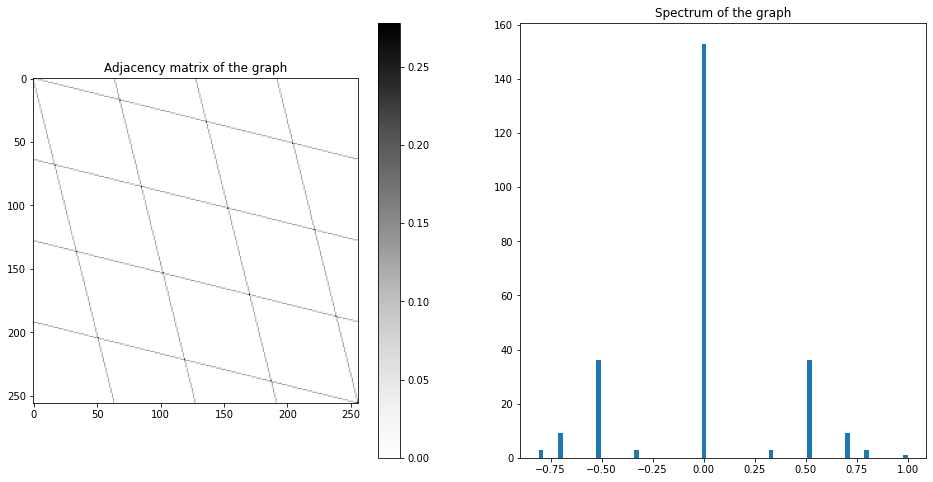

In [ ]:
# Create a De Bruijn graphs
n_x = 4  # codebook size of the acoustic features
n_y = 3  # vocabulary size of the text features
n = 4  # n-gram size
l = 20  # Sentence size
N_x = 25600
N_y = 25600

A = make_debruijn(n, n_x)
A = A + A.T
Di = np.diag(1./(A.sum(-1)+1e-10))
T = Di @ A
p_0 = make_initial_prob(n_x**n)
O_true = make_asr(n_x, n_y) 

X, Y = create_asr_u_dataset(
    p_0, 
    T, 
    O_true, 
    n_x, 
    n_y, 
    n, 
    l, 
    N_x, 
    N_y,
)
T_est = estimate_T(X, n_x, n)
plot_graph(T_est)

In [ ]:
print(os.getcwd())
save_dir = "/content/debruijn_4_4_25600"
save_asr_u_dataset(
    X, 
    O_true, 
    split_dict={
        "train": [0, 23040],
        "valid": [23040, 25600],
        "all": [0, 25600],
    }, 
    save_dir=save_dir,
)
make_archive(save_dir, save_dir+".zip")

/content


In [ ]:
plot_graph(T)

NameError: ignored

####1.2 PER vs sample sizes

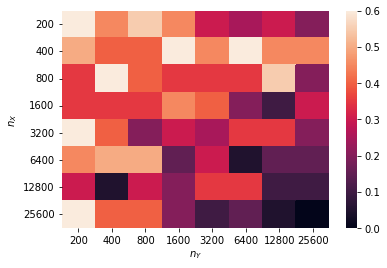

In [ ]:
n_trials = 5
data_dict = {
    r"$n_X$": [],
    r"$n_Y$": [],
    "PER": [],
} 
N = len(X)
for N_x in [200, 400, 800, 1600, 3200, 6400, 12800, 25600]:
    for N_y in [200, 400, 800, 1600, 3200, 6400, 12800, 25600]:
        avg_per = 0
        for _ in range(n_trials):
          x_idxs = np.random.permutation(N)[:N_x]
          y_idxs = np.random.permutation(N)[:N_y]
          P_X = estimate_P_X(X[x_idxs], n_x, l)
          P_Y = estimate_P_Y(Y[y_idxs], n_y, l)
          
          # Least-square solution of the matrix equation
          O_pred = exact_asr_u(P_X, P_Y)
          avg_per += calc_per(O_pred, O_true)
        avg_per /= n_trials
        data_dict[r"$n_X$"].append(N_x)
        data_dict[r"$n_Y$"].append(N_y)
        data_dict["PER"].append(avg_per)
df = pd.DataFrame(data_dict)
df = df.pivot(r"$n_X$", r"$n_Y$", "PER")
sns.heatmap(df)

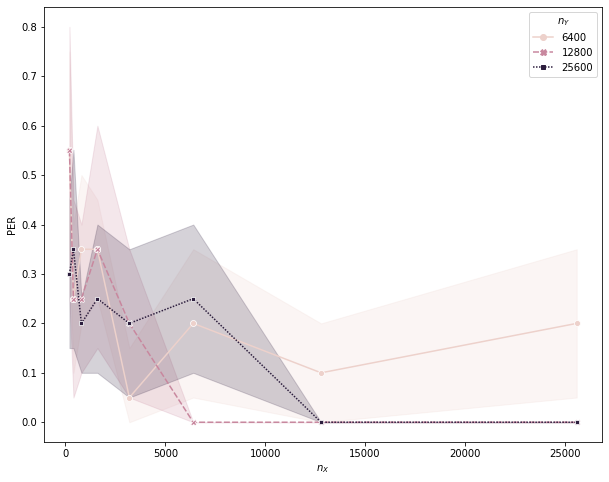

In [ ]:
n_trials = 5
data_dict = {
    r"$n_X$": [],
    r"$n_Y$": [],
    "PER": [],
} 
N = len(X)
for N_x in [200, 400, 800, 1600, 3200, 6400, 12800, 25600]:
    for N_y in [6400, 12800, 25600]:
        avg_per = 0
        for _ in range(n_trials):
          x_idxs = np.random.permutation(N)[:N_x]
          y_idxs = np.random.permutation(N)[:N_y]
          P_X = estimate_P_X(X[x_idxs], n_x, l)
          P_Y = estimate_P_Y(Y[y_idxs], n_y, l)
          
          # Least-square solution of the matrix equation
          O_pred = exact_asr_u(P_X, P_Y)
          data_dict[r"$n_X$"].append(N_x)
          data_dict[r"$n_Y$"].append(N_y)
          data_dict["PER"].append(
              calc_per(O_pred, O_true)
          )
df = pd.DataFrame(data_dict)
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(
    data=data_dict,
    x=r"$n_X$",
    y="PER",
    hue=r"$n_Y$",
    style=r"$n_Y$",
    markers=True,
)

### 2. Random graph

#### 2.1 Create speech and text datasets

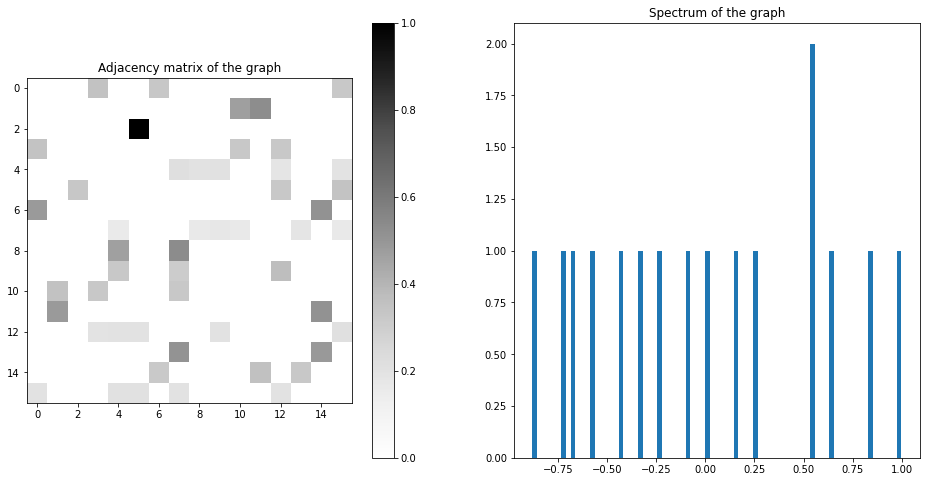

In [ ]:
n_x = 4  # codebook size of the acoustic features
n_y = 3  # vocabulary size of the text features
n = 2  # n-gram size
p = 0.3  # edge probability of the ER graph  
l = 10  # Sentence size
N_x = 2560
N_y = 2560

m = n_x**n
A = make_erdos_renyi(m, p)
Di = np.diag(1./(A.sum(-1)+1e-10))
T = Di @ A
# Avoid p_0 being parallel to eigenvectors of T,
# which are statistically more likely to be dense
# vectors
p_0 = np.eye(m)[0]
O_true = make_asr(n_x, n_y) 

X, Y = create_asr_u_dataset(
    p_0, 
    T, 
    O_true, 
    n_x, 
    n_y, 
    n, 
    l, 
    N_x, 
    N_y,
)
T_est = estimate_T(X, n_x, n)
plot_graph(T_est)

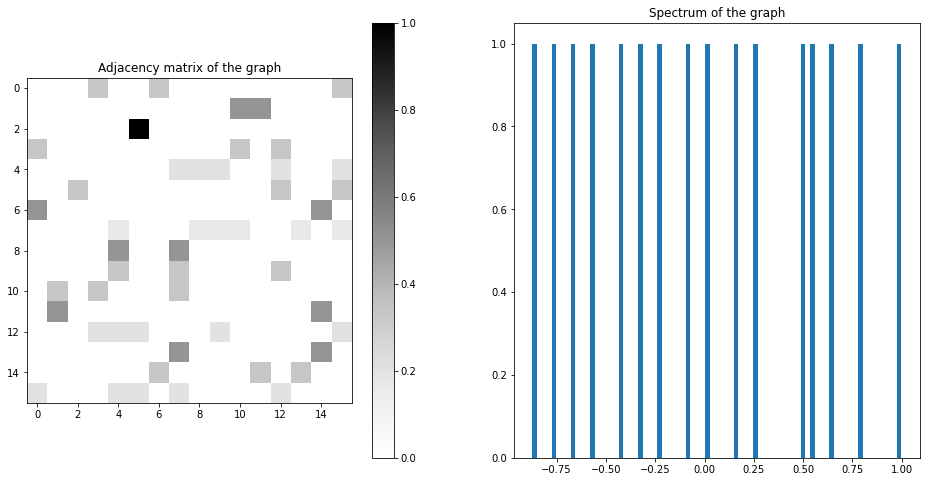

In [ ]:
plot_graph(T)

#### 2.2 PER vs sample sizes

$n_Y$  200    400    800    1600   3200   6400   12800  25600
$n_X$                                                        
200     0.10   0.05   0.00   0.10   0.05   0.00    0.0   0.05
400     0.00   0.15   0.00   0.00   0.00   0.00    0.0   0.05
800     0.15   0.05   0.05   0.00   0.05   0.05    0.0   0.00
1600    0.20   0.10   0.10   0.10   0.10   0.05    0.0   0.05
3200    0.15   0.25   0.05   0.05   0.05   0.00    0.0   0.00
6400    0.15   0.05   0.10   0.00   0.10   0.00    0.0   0.00
12800   0.10   0.05   0.05   0.05   0.00   0.05    0.0   0.00
25600   0.15   0.15   0.15   0.10   0.00   0.00    0.0   0.00


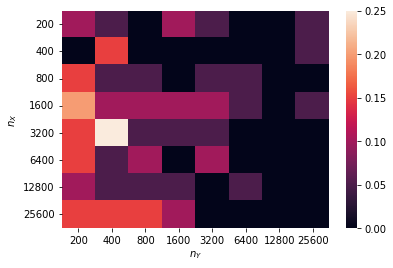

In [ ]:
n_trials = 5
data_dict = {
    r"$n_X$": [],
    r"$n_Y$": [],
    "PER": [],
} 
N = len(X)
for N_x in 200*(2**np.arange(8)):
    for N_y in 200*(2**np.arange(8)):
        avg_per = 0
        for _ in range(n_trials):
          x_idxs = np.random.permutation(N)[:N_x]
          y_idxs = np.random.permutation(N)[:N_y]
          P_X = estimate_P_X(X[x_idxs], n_x, l)
          P_Y = estimate_P_Y(Y[y_idxs], n_y, l)
          
          # Least-square solution of the matrix equation
          O_pred = exact_asr_u(P_X, P_Y)
          avg_per += calc_per(O_pred, O_true)
        avg_per /= n_trials
        data_dict[r"$n_X$"].append(N_x)
        data_dict[r"$n_Y$"].append(N_y)
        data_dict["PER"].append(avg_per)
df = pd.DataFrame(data_dict)
df = df.pivot(r"$n_X$", r"$n_Y$", "PER")
sns.heatmap(df)

#### 2.3 PER vs smallest singular value

Acoustic feature codebook size: 10
N-gram size: 1
[0.1        0.21111111 0.32222222 0.43333333 0.54444444 0.65555556
 0.76666667 0.87777778 0.98888889 1.1       ]
Smallest singular values of P_X: 0.0
Smallest singular values of P_X: 0.0
Smallest singular values of P_X: 2.7975336689909276e-05


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


Smallest singular values of P_X: 7.822591007820681e-07
Smallest singular values of P_X: 1.5989539416412312e-06
Smallest singular values of P_X: 1.2520862737109078e-16
Smallest singular values of P_X: 3.916124913595954e-17
Smallest singular values of P_X: 2.085016220323226e-17
Smallest singular values of P_X: 2.9952575573059085e-35
Smallest singular values of P_X: 3.590344444323463e-50


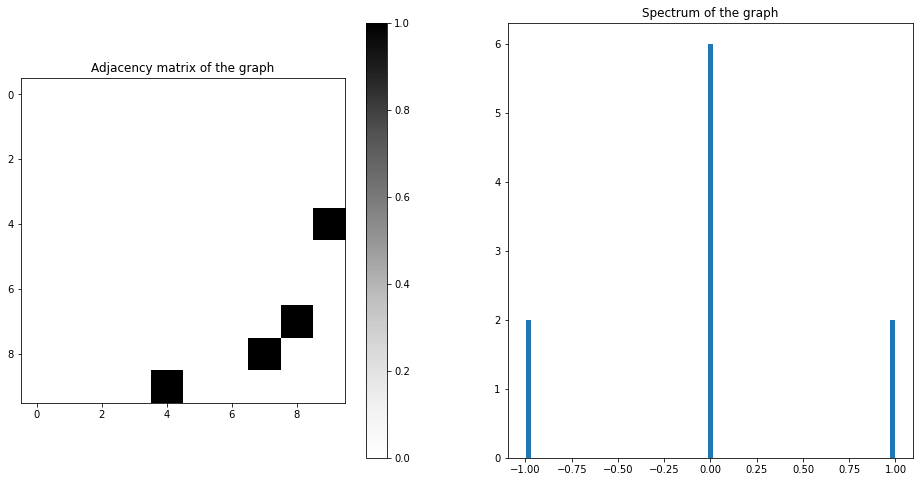

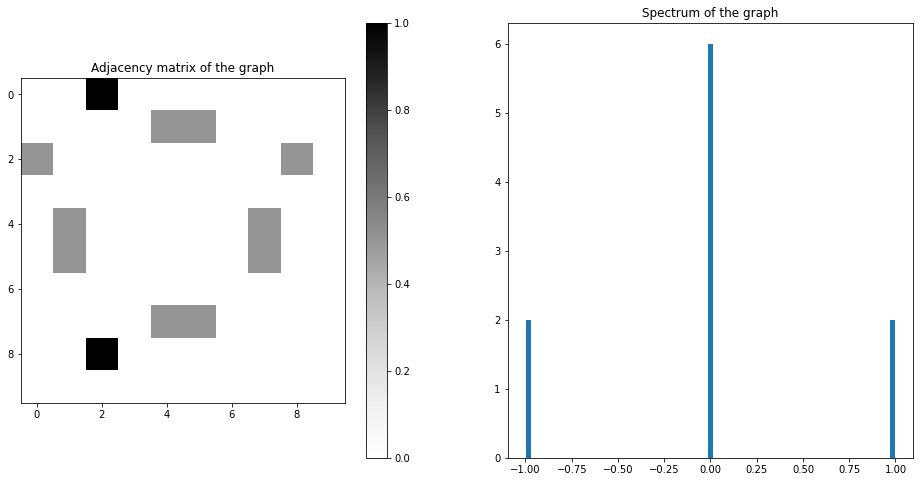

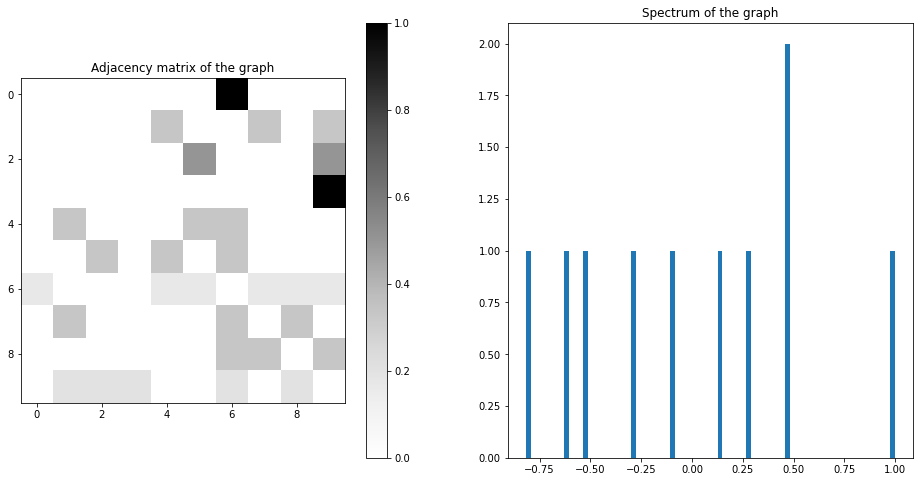

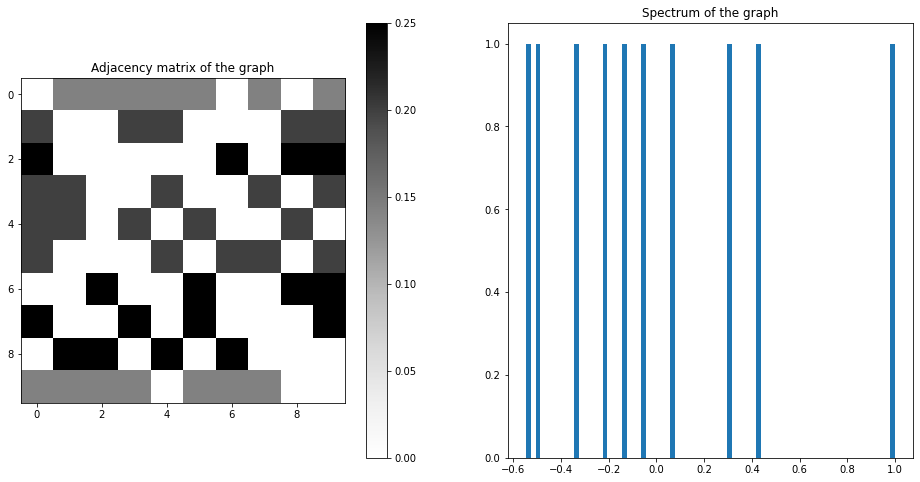

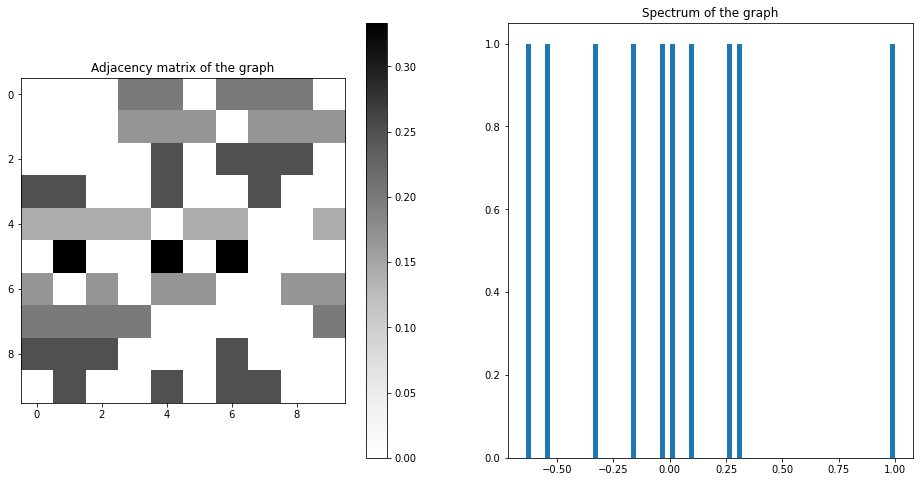

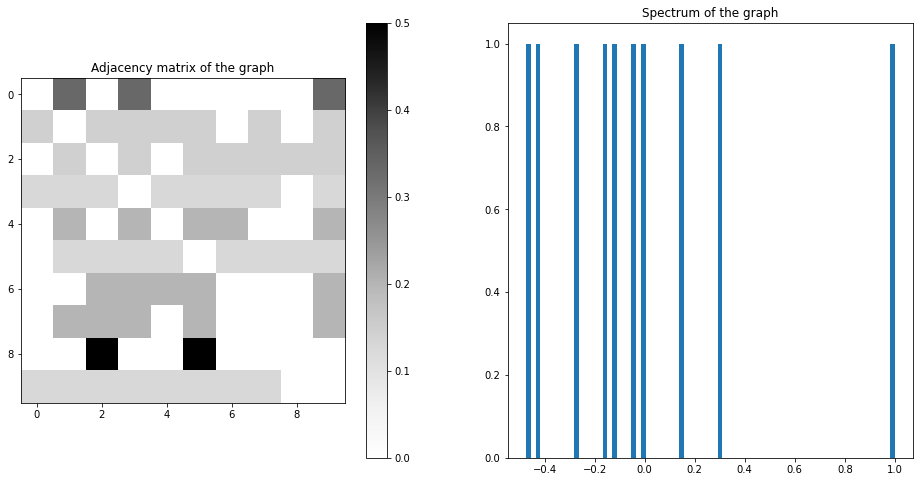

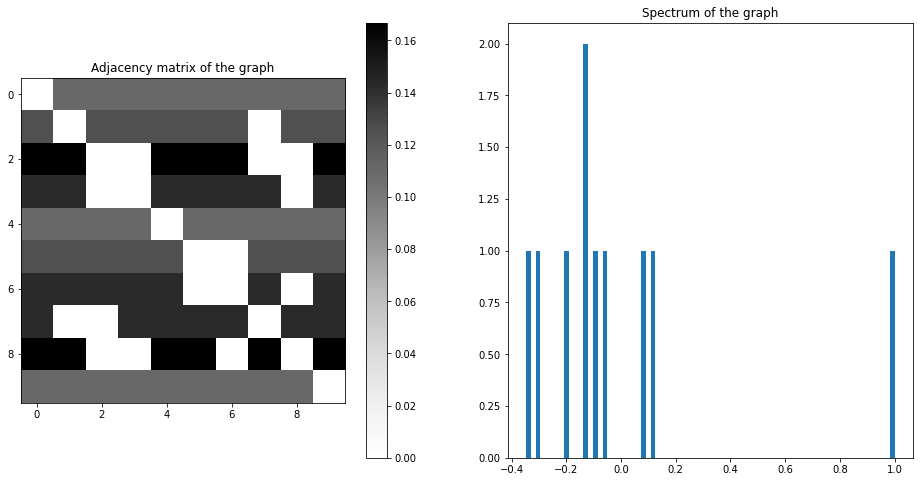

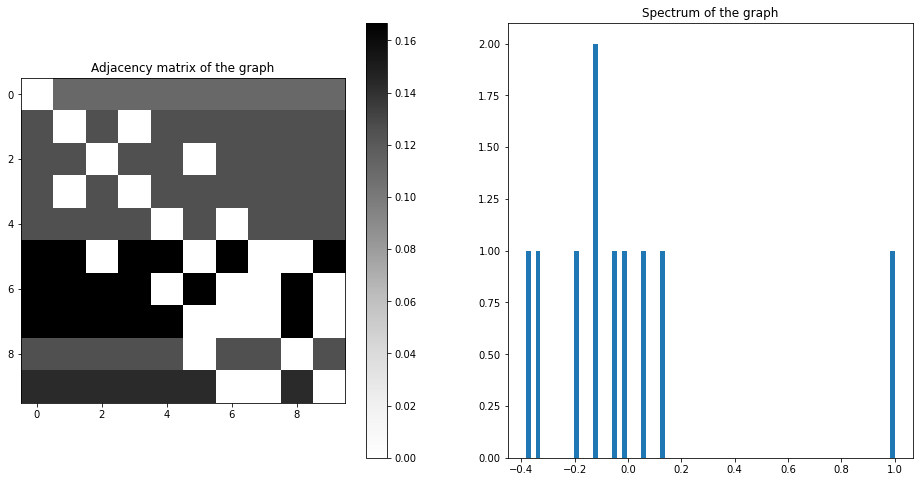

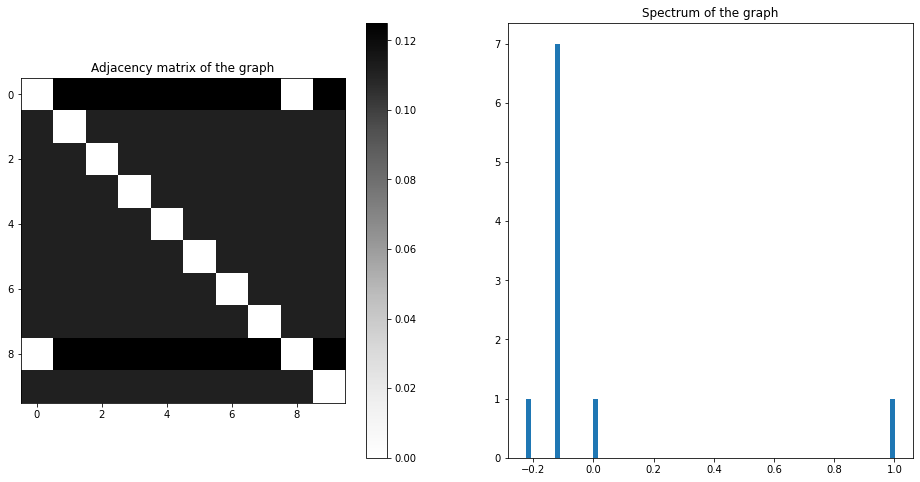

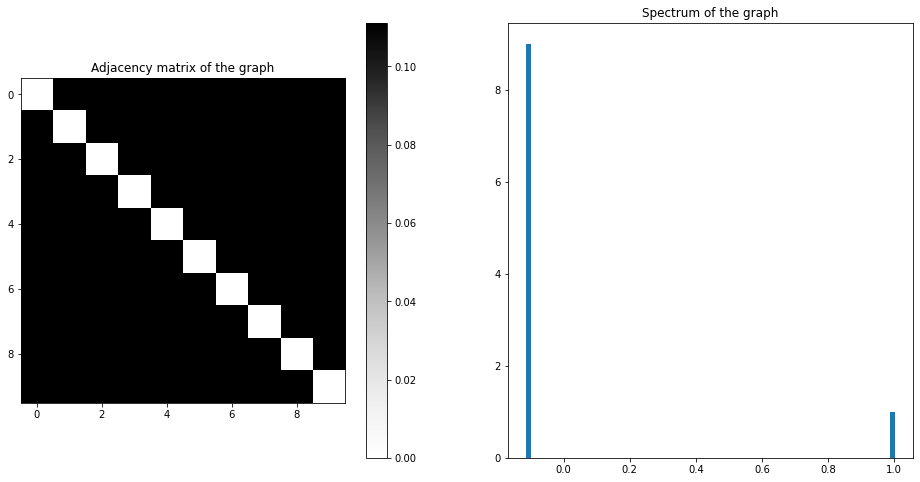

In [ ]:
random.seed(0)
np.random.seed(0)

n_x = 10  # codebook size of the acoustic features
n_y = 10  # vocabulary size of the text features
n = 1  # n-gram size
l = 100  # Sentence size

# Avoid p_0 being parallel to eigenvectors of T,
# which are statistically more likely to be dense
# vectors
m = n_x**n
p_0 = np.eye(m)[0] #make_initial_prob(m)
O_true = np.eye(n_x)[np.random.permutation(n_x)]
print(
    f"Acoustic feature codebook size: {n_x}\n"
    f"N-gram size: {n}" 
)

print(np.linspace(0.1, 1.1, 10))
for p in np.linspace(0.1, 1.1, 10):  # Group action set size
  A = make_erdos_renyi(m, p)
  Di = np.diag(1./(A.sum(-1)+1e-10))
  T = Di @ A
  P_X, P_Y = make_asr_u_matrices(
      p_0, T, O_true, l, n,
  )
  s_min = np.linalg.svd(P_X)[1].min()
  print(f"Smallest singular values of P_X: {s_min}")
  plot_graph(T)

In [ ]:
random.seed(0)
np.random.seed(0)

n_x = 10  # codebook size of the acoustic features
n_y = 10  # vocabulary size of the text features
n = 2  # n-gram size
m = n_x**n
l = 80  # Sentence size
N_x = 2560
N_y = 2560
data_dict = {
    "Codebook size": [],
    r"$\sigma_{\min}(P^X)$": [],
    "PER": [],
}
p_0 = np.eye(m)[0]
O_true = np.eye(n_x)[np.random.permutation(n_x)]

print(np.linspace(0.1, 1.0, 10))
for p in np.linspace(0.1, 1.0, 10):  # Group action set size
    A = make_erdos_renyi(m, p)
    Di = np.diag(1./(A.sum(-1)+1e-10))
    T = Di @ A
    print(A)
    P_X, P_Y = make_asr_u_matrices(
        p_0, T, O_true, l, n,
    )
    
    # Sample sequences from the probability distribution
    X, Y = create_asr_u_dataset(
        p_0, T, O_true, n_x, n_y, n, l, N_x, N_y,
    )
    P_X_est = estimate_P_X(
        X, n_x, n, l,
    )
    P_Y_est = estimate_P_Y(
        Y, n_y, n, l,
    )
    E_X = np.abs((P_X - P_X_est) @ O_true)
    E_Y = np.abs(P_Y - P_Y_est)
    s_min = sorted(np.linalg.svd(P_X)[1])[0]
    per_upper_bound = (np.linalg.norm(E_X, 2) + np.linalg.norm(E_Y, 2)) / (s_min * n_x)
    print(
        "Estimation error for P_X O: ", 
        np.linalg.norm(E_X, 2) / np.linalg.norm(P_X, 2),
    )
    print(
        "Estimation error for P_Y: ", 
        np.linalg.norm(E_Y, 2) / np.linalg.norm(P_Y, 2),
    )
    print(
        "Least singular value of P_X: ",
        s_min,
    )
    print(
        "Upper bound on assignment matrix error: ",
        per_upper_bound,
    )

    # Least-square solution of the matrix equation
    O_pred = exact_asr_u(P_X_est, P_Y_est)
    data_dict[r"Codebook size"].append(r"$|\mathcal{X}|=$"+str(n_x))
    data_dict[r"$\sigma_{\min}(P^X)$"].append(s_min)
    per = calc_per(O_pred, O_true)
    data_dict["PER"].append(per)
    
    # Save data
    """
    save_dir = f"/content/cycle__nx_{n_x}_n_{n}_Nx_{N_x}_level_{i_w}"
    save_asr_u_dataset(
        X, 
        O_true, 
        split_dict={
            "train": [0, 2304],
            "valid": [2304, 2560],
            "all": [0, 2560],
        }, 
        save_dir=save_dir, 
        err_rate=per,
    )
    """

Text(0.5, 1.0, 'Finite sample ASR-U PER vs. smallest $\\sigma_{\\min}$')

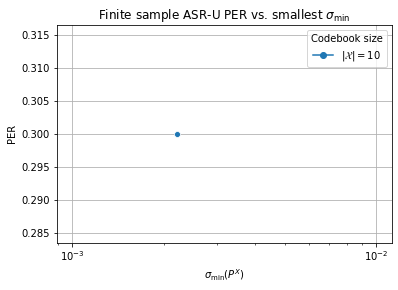

In [ ]:
# Plot PER vs num. of eigenvalues using seaborn
df = pd.DataFrame(data_dict)
fig, ax = plt.subplots()
sns.lineplot(
    data=df,
    x=r"$\sigma_{\min}(P^X)$",
    y="PER",
    hue="Codebook size",
    style="Codebook size",
    markers=True,
    dashes=False,
)
plt.grid()
ax.set_xscale("log")
plt.title(r"Finite sample ASR-U PER vs. smallest $\sigma_{\min}$")

### 3. Circulant graph

#### 3.1 Visualizing the Markov graph



Acoustic feature codebook size: 10
N-gram size: 2
Least singular values of P_X: 3.096940343384843e-33


/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


Least singular values of P_X: 1.2937845012649683e-11
Least singular values of P_X: 1.67634655151033e-08
Least singular values of P_X: 3.508579063756184e-08
Least singular values of P_X: 5.253134381718209e-07
Least singular values of P_X: 5.026295417277933e-17
Least singular values of P_X: 1.482197091731623e-05
Least singular values of P_X: 2.7262215988950884e-05
Least singular values of P_X: 0.0016011814357656856
Least singular values of P_X: 0.044199214670844304


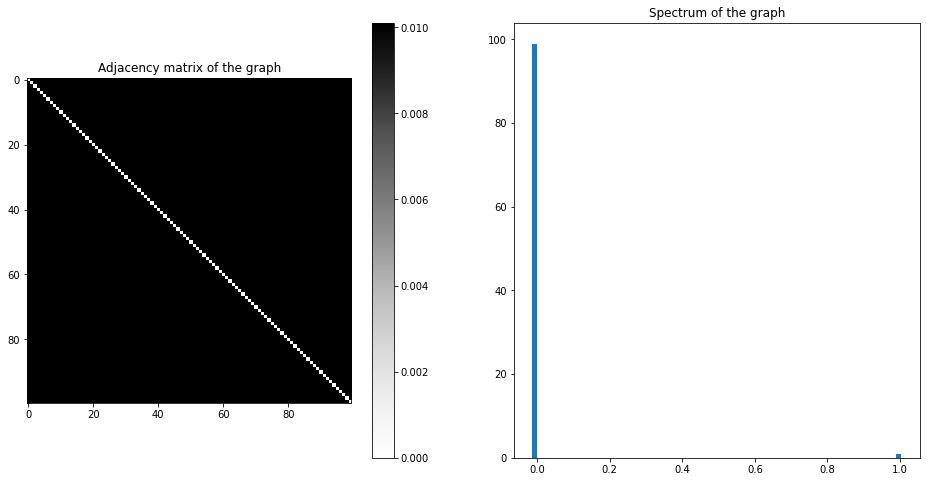

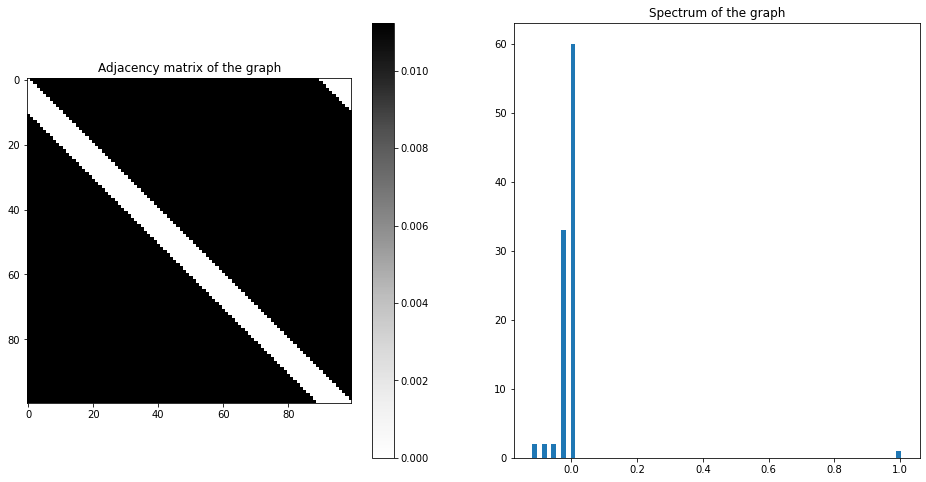

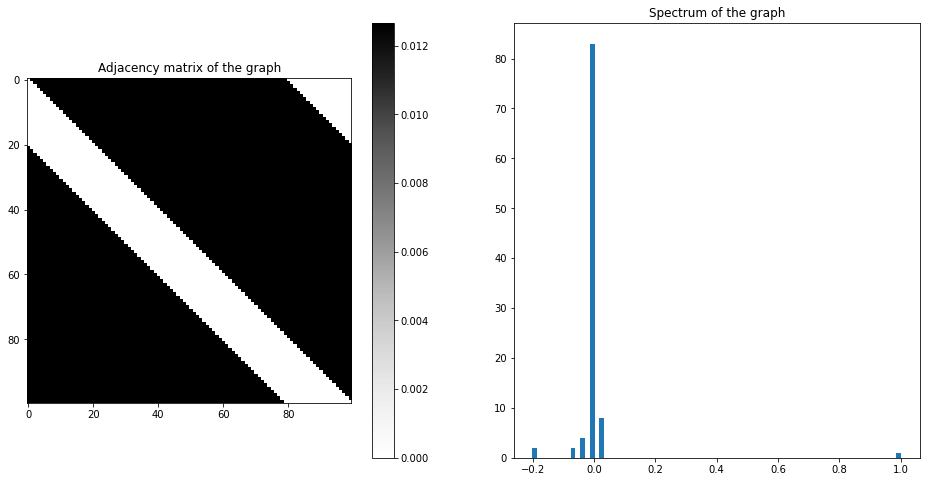

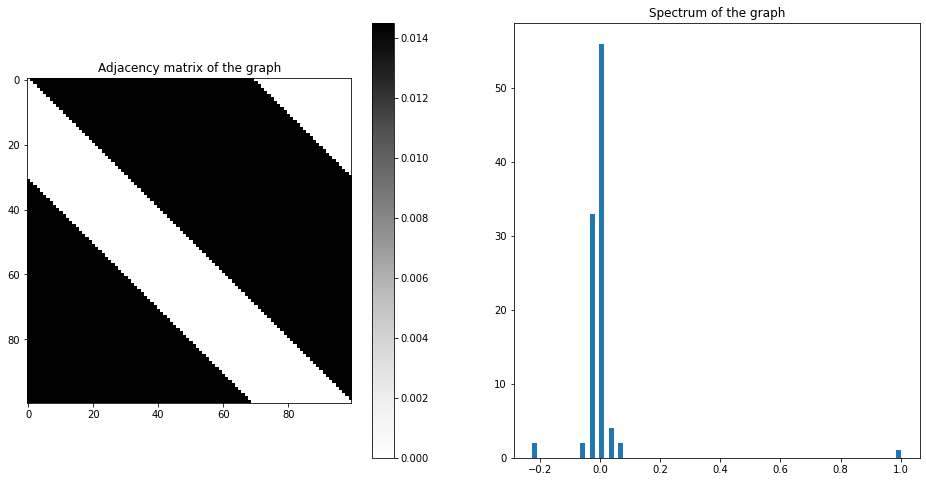

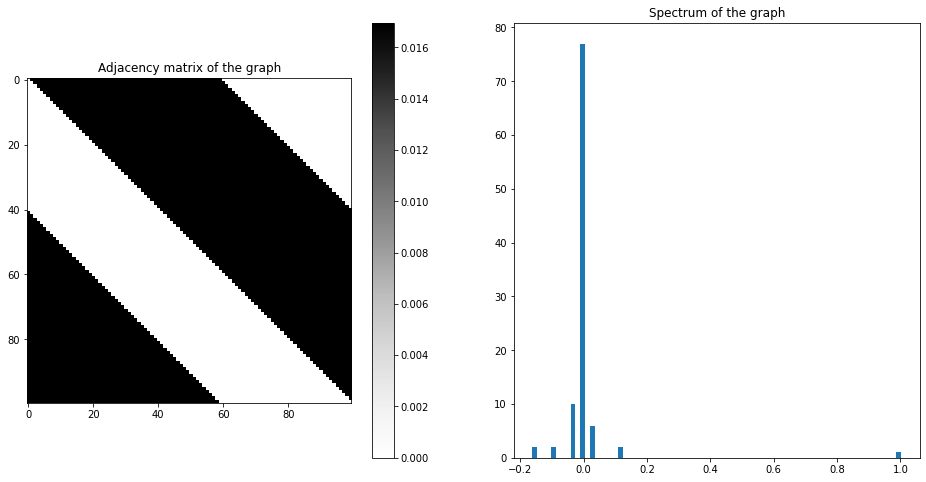

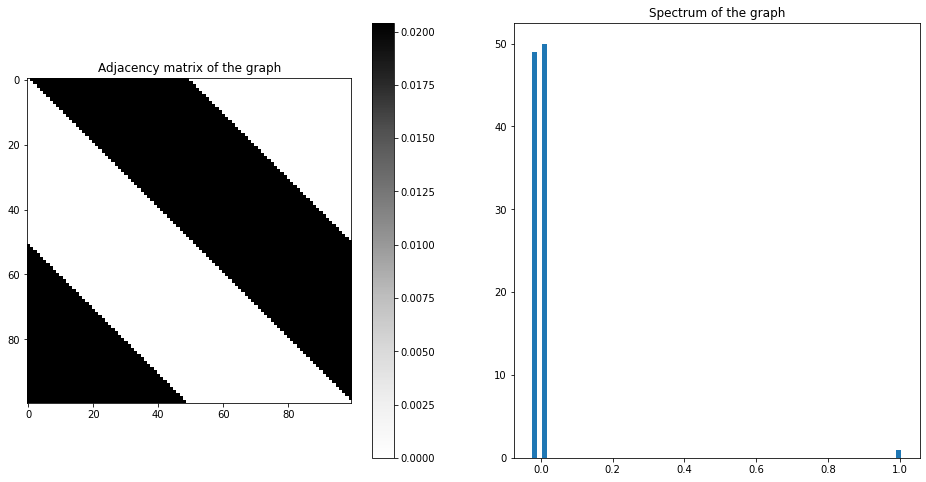

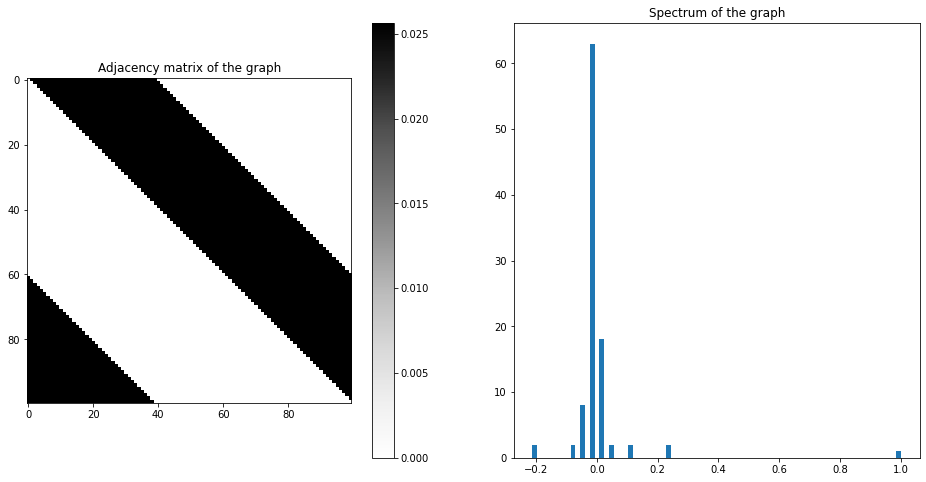

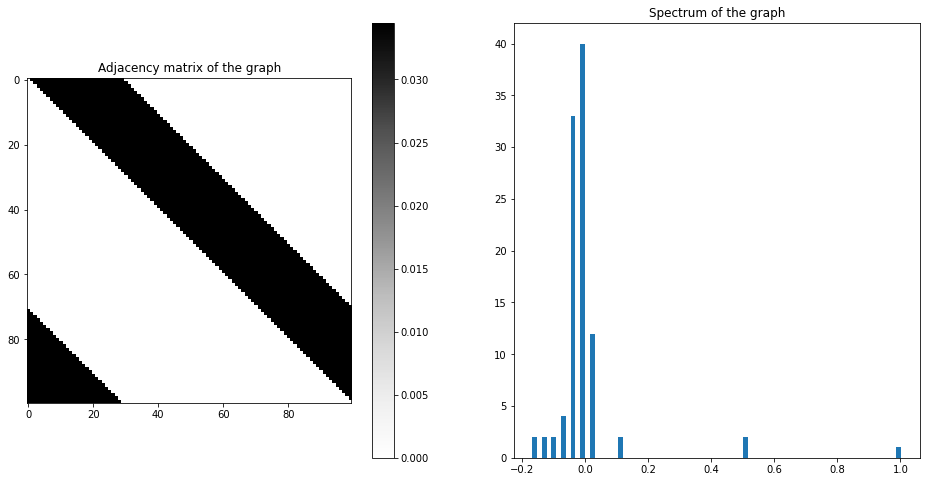

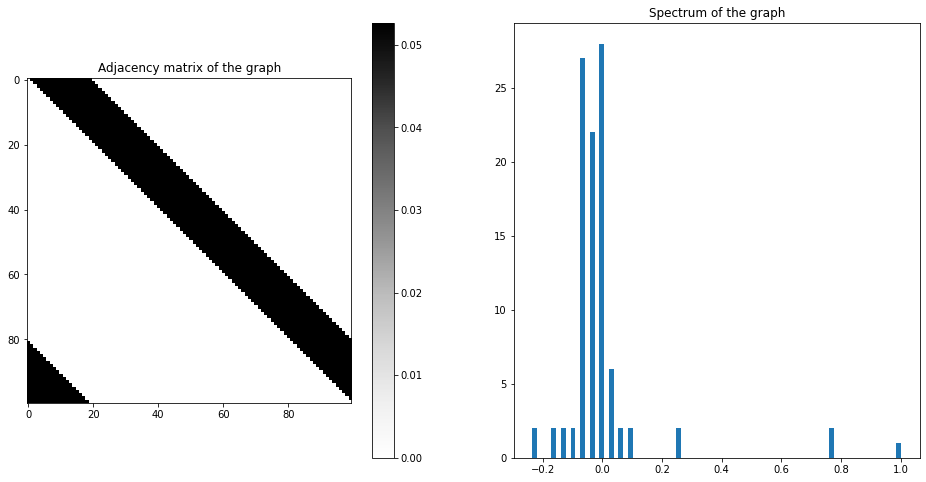

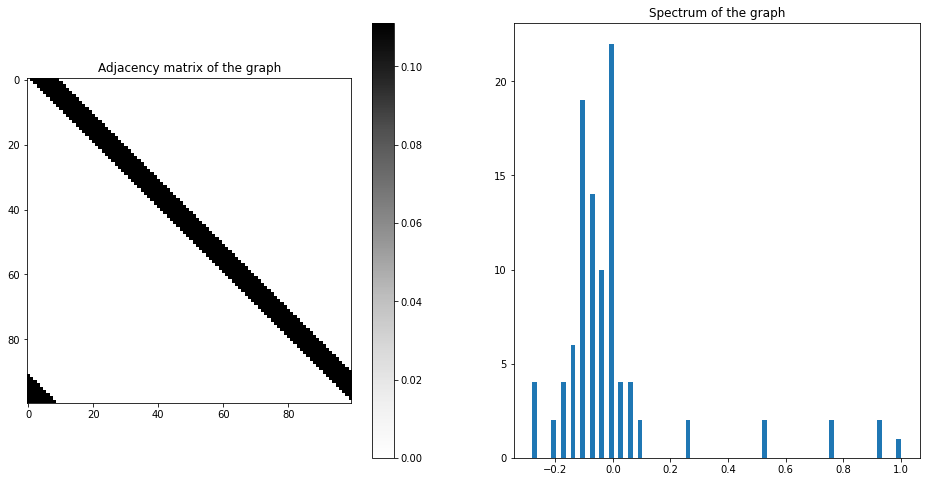

In [ ]:
# Create a sequence of circulant graphs with an increasing set of group actions
n_x = n_y = 10  # codebook size of the acoustic features
n = 2  # n-gram size
l = 20
N_x = 2560
N_y = 2560
print(
    f"Acoustic feature codebook size: {n_x}\n"
    f"N-gram size: {n}" 
)
m = n_x**n  # number of n-grams
p_0 = np.eye(m)[0] #make_initial_prob(m)
O_true = np.eye(n_x)[np.random.permutation(n_x)]

for level, n_c in enumerate(range(99, 0, -10)):
    S = list(range(1, n_c+1))
    ws = [1]*n_c
    #for _ in range(n_c-1):
    #    ws.append((1-w)/(n_c-1))
    A = make_circulant(m, S, ws)
    Di = np.diag(1./A.sum(-1))
    T = Di @ A
    P_X, P_Y = make_asr_u_matrices(
        p_0, T, O_true, l, n,
    )
    plot_graph(T)
    s_min = np.linalg.svd(P_X)[1].min()
    print(f"Least singular values of P_X: {s_min}")

#### 3.2 PER vs $\sigma_{\min}(P^X)$

In [ ]:
random.seed(0)
np.random.seed(0)

N_x = 2560
N_y = 2560
n_trials = 1
n = 2  # n-gram size
l = 80 # Utterance length
data_dict = {
    "Codebook size": [],
    r"$\sigma_{\min}(P^X)$": [],
    "PER": [],
}
for n_x in range(10, 11):
    n_y = n_x
    m = n_x**n  # number of n-grams
    # Create matrices used in ASR-U
    p_0 = make_initial_prob_zipf(m, a=1)
    O_true = np.eye(n_x)[np.random.permutation(n_x)]
    for level, n_c in enumerate(range(1, 81, 8)):
        # A = make_cycle(m, w)
        S = list(range(1, n_c+1))
        ws = [1]*n_c
        #for _ in range(n_c-1):
        #    ws.append((1-w)/(n_c-1))
        A = make_circulant(m, S, ws)
        # print(A)
        Di = np.diag(1./A.sum(-1))
        T = Di @ A
        P_X, P_Y = make_asr_u_matrices(
            p_0, T, O_true, l, n,
        )

        # Sample sequences from the probability distribution
        X, Y = create_asr_u_dataset(
            p_0, T, O_true, n_x, n_y, n, l, N_x, N_y,
        )
        P_X_est = estimate_P_X(
            X, n_x, n, l,
        )
        P_Y_est = estimate_P_Y(
            Y, n_y, n, l,
        )
        E_X = np.abs((P_X - P_X_est) @ O_true)
        E_Y = P_Y - P_Y_est
        s_min = sorted(np.linalg.svd(P_X)[1])[0]
        E_Y_minus_E_X = np.linalg.norm(E_Y - E_X, 2) 
        s_min_thres = 2 * E_Y_minus_E_X
        per_upper_bound = E_Y_minus_E_X / (s_min * n_x)
        
        print(
            "Estimation error for P_X O: ", 
            np.linalg.norm(E_X, 2), #/ np.linalg.norm(P_X, 2),
        )
        print(
            "Estimation error for P_Y: ", 
            np.linalg.norm(E_Y, 2), #/ np.linalg.norm(P_Y, 2),
        )
        print(
            "Least singular value of P_X: ",
            s_min,
        )
        print(
            "Phase transition threshold: ",
            s_min_thres,
        )
        print(
            "Upper bound on assignment matrix error: ",
            per_upper_bound,
        )

        # Least-square solution of the matrix equation
        O_pred = exact_asr_u(P_X_est, P_Y_est)
        data_dict[r"Codebook size"].append(r"$|\mathcal{X}|=$"+str(n_x))
        data_dict[r"$\sigma_{\min}(P^X)$"].append(s_min)
        per = calc_per(O_pred, O_true)
        data_dict["PER"].append(per)
        
        # Save data
        save_dir = f"/content/phase_transition_circulant/circulant__nx_{n_x}_n_{n}_Nx_{N_x}_level_{level}"
        save_asr_u_dataset(
            X, 
            Y,
            O_true, 
            split_dict={
                "train": [0, 2304],
                "valid": [2304, 2560],
            }, 
            save_dir=save_dir,
            err_rate=per,
        )

Estimation error for P_X O:  0.1750204020014792
Estimation error for P_Y:  0.11494340142774909
Least singular value of P_X:  0.4723363335149252
Phase transition threshold:  0.35575663833189697
Upper bound on assignment matrix error:  0.03765924967962003
Estimation error for P_X O:  0.1913226227135319
Estimation error for P_Y:  0.09677177703931371
Least singular value of P_X:  0.021849735766667936
Phase transition threshold:  0.3842946932513066
Upper bound on assignment matrix error:  0.8794035254136878
Estimation error for P_X O:  0.1915146683982468
Estimation error for P_Y:  0.0937753036006988
Least singular value of P_X:  0.0031220349923075288
Phase transition threshold:  0.3852294904582391
Upper bound on assignment matrix error:  6.169525508320968
Estimation error for P_X O:  0.20589369999717225
Estimation error for P_Y:  0.09359530967317384
Least singular value of P_X:  0.0017140058646738859
Phase transition threshold:  0.4153311562556651
Upper bound on assignment matrix error:  12

Text(0.5, 1.0, 'Finite sample ASR-U PER vs. smallest $\\sigma_{\\min}$')

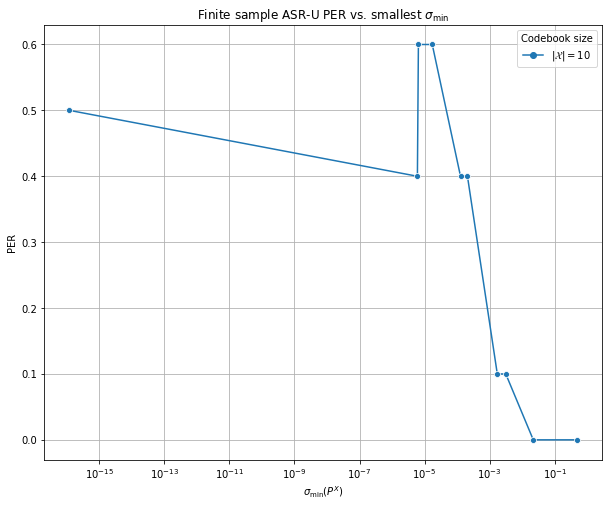

In [ ]:
# Plot PER vs num. of eigenvalues using seaborn
df = pd.DataFrame(data_dict)
fig, ax = plt.subplots()
sns.lineplot(
    data=df,
    x=r"$\sigma_{\min}(P^X)$",
    y="PER",
    hue="Codebook size",
    style="Codebook size",
    markers=True,
    dashes=False,
)
plt.grid()
ax.set_xscale("log")
plt.title(r"Finite sample ASR-U PER vs. smallest $\sigma_{\min}$")

In [ ]:
# Zip all the files
save_dir = f"/content/phase_transition_circulant"
make_archive(save_dir, save_dir+".zip")

#### 3.3 Effect of sampling size

In [ ]:
random.seed(0)
np.random.seed(0)

n_trials = 1
n = 2  # n-gram size
l = 80 # Utterance length
n_y = n_x = 10 # Vocab size
m = n_x**n  # number of n-grams

n_c = 25
S = list(range(1, n_c+1))
l = 80 # Utterance length
level = (n_c - 1) // 8
ws = [1]*n_c

In [ ]:
p_0 = make_initial_prob_zipf(m, a=1)
O_true = np.eye(n_x)[np.random.permutation(n_x)]
A = make_circulant(m, S, ws)
Di = np.diag(1./A.sum(-1))
T = Di @ A
P_X, P_Y = make_asr_u_matrices(
    p_0, T, O_true, l, n,
)
N_x = N_y = 51200

# Sample sequences from the probability distribution
X_all, Y_all = create_asr_u_dataset(
    p_0, T, O_true, n_x, n_y, n, l, N_x, N_y,
)

# Save data
save_dir = f"/content/phase_transition_circulant/circulant__nx_{n_x}_n_{n}_Nx_{N_x}_level{level}"
save_asr_u_dataset(
    X_all, 
    Y_all,
    O_true, 
    split_dict={
        "train": [0, 48640],
        "valid": [48640, 51200],
    }, 
    save_dir=save_dir,
    err_rate=per,
)

In [ ]:
# Zip all the files
save_dir = f"/content/phase_transition_circulant/circulant__nx_10_n_2_Nx_{N_x}_level{level}"
make_archive(save_dir, save_dir+".zip")

In [ ]:
data_dict = {
    "Codebook size": [],
    r"$\sigma_{\min}(P^X)$": [],
    r"$n_x$": [],
    r"$n_y$": [],
    "PER": [],
}
for N_x in [51200, 12800, 3200, 800, 200]:
  for N_y in [51200, 12800, 3200, 800, 200]:
    # Subsample the data
    sp_idxs = np.random.permutation(51200)[:N_x]
    txt_idxs = np.random.permutation(51200)[:N_y]
    X = [X_all[i] for i in sp_idxs]
    Y = [Y_all[i] for i in txt_idxs]

    P_X_est = estimate_P_X(
        X, n_x, n, l,
    )
    P_Y_est = estimate_P_Y(
        Y, n_y, n, l,
    )
    E_X = np.abs((P_X - P_X_est) @ O_true)
    E_Y = P_Y - P_Y_est
    s_min = sorted(np.linalg.svd(P_X)[1])[0]
    E_Y_minus_E_X = np.linalg.norm(E_Y - E_X, 2) 
    s_min_thres = 2 * E_Y_minus_E_X
    per_upper_bound = E_Y_minus_E_X / (s_min * n_x)

    # Least-square solution of the matrix equation
    O_pred = exact_asr_u(P_X_est, P_Y_est)
    data_dict[r"Codebook size"].append(r"$|\mathcal{X}|=$"+str(n_x))
    data_dict[r"$\sigma_{\min}(P^X)$"].append(s_min)
    per = calc_per(O_pred, O_true)
    data_dict["PER"].append(per)
    data_dict[r"$n_x$"].append(N_x)
    data_dict[r"$n_y$"].append(N_y)

    print(
        "Estimation error for P_X O: ", 
        np.linalg.norm(E_X, 2), #/ np.linalg.norm(P_X, 2),
    )
    print(
        "Estimation error for P_Y: ", 
        np.linalg.norm(E_Y, 2), #/ np.linalg.norm(P_Y, 2),
    )
    print(
        "Least singular value of P_X: ",
        s_min,
    )
    print(
        "Phase transition threshold: ",
        s_min_thres,
    )
    print(
        "Upper bound on assignment matrix error: ",
        per_upper_bound,
    )
    print(
        "PER: ",
        per,
    )

Estimation error for P_X O:  0.04300460508824982
Estimation error for P_Y:  0.020476462024329584
Least singular value of P_X:  0.0017140058646738859
Phase transition threshold:  0.08654427916009573
Upper bound on assignment matrix error:  2.524620275338498
PER:  0.0
Estimation error for P_X O:  0.04300460508824982
Estimation error for P_Y:  0.04421969167533041
Least singular value of P_X:  0.0017140058646738859
Phase transition threshold:  0.09288433342466043
Upper bound on assignment matrix error:  2.709568716742197
PER:  0.0
Estimation error for P_X O:  0.04300460508824982
Estimation error for P_Y:  0.0831604179849965
Least singular value of P_X:  0.0017140058646738859
Phase transition threshold:  0.16721925817419422
Upper bound on assignment matrix error:  4.878024679513278
PER:  0.0
Estimation error for P_X O:  0.04300460508824982
Estimation error for P_Y:  0.16327672792273715
Least singular value of P_X:  0.0017140058646738859
Phase transition threshold:  0.3273979552752003
Upper 

         Codebook size  $\sigma_{\min}(P^X)$  $n_x$  $n_y$  PER
0   $|\mathcal{X}|=$10              0.001714  51200  51200  0.0
1   $|\mathcal{X}|=$10              0.001714  51200  12800  0.0
2   $|\mathcal{X}|=$10              0.001714  51200   3200  0.0
3   $|\mathcal{X}|=$10              0.001714  51200    800  0.3
4   $|\mathcal{X}|=$10              0.001714  51200    200  0.5
5   $|\mathcal{X}|=$10              0.001714  12800  51200  0.0
6   $|\mathcal{X}|=$10              0.001714  12800  12800  0.0
7   $|\mathcal{X}|=$10              0.001714  12800   3200  0.1
8   $|\mathcal{X}|=$10              0.001714  12800    800  0.4
9   $|\mathcal{X}|=$10              0.001714  12800    200  0.4
10  $|\mathcal{X}|=$10              0.001714   3200  51200  0.1
11  $|\mathcal{X}|=$10              0.001714   3200  12800  0.1
12  $|\mathcal{X}|=$10              0.001714   3200   3200  0.2
13  $|\mathcal{X}|=$10              0.001714   3200    800  0.3
14  $|\mathcal{X}|=$10              0.00

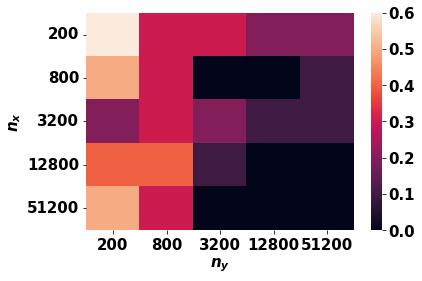

In [ ]:
df = pd.DataFrame(data_dict)
print(df)
df = df.pivot(r"$n_x$", r"$n_y$", "PER")
sns.heatmap(df)

#### 3.4 Effect of sequence lengths

In [ ]:
random.seed(0)
np.random.seed(0)

n_trials = 1
n = 2  # n-gram size
l = 80 # Utterance length
n_y = n_x = 10 # Vocab size
m = n_x**n  # number of n-grams

n_c = 25
S = list(range(1, n_c+1))
l = 80 # Utterance length
level = (n_c - 1) // 8
ws = [1]*n_c

In [ ]:
p_0 = make_initial_prob_zipf(m, a=1)
O_true = np.eye(n_x)[np.random.permutation(n_x)]
A = make_circulant(m, S, ws)
Di = np.diag(1./A.sum(-1))
T = Di @ A
P_X, P_Y = make_asr_u_matrices(
    p_0, T, O_true, l, n,
)
N_x = N_y = 12800

# Sample sequences from the probability distribution
X_all, Y_all = create_asr_u_dataset(
    p_0, T, O_true, n_x, n_y, n, l, N_x, N_y,
)

# Save data
save_dir = f"/content/phase_transition_circulant/circulant__nx_{n_x}_n_{n}_Nx_{N_x}_level{level}"
save_asr_u_dataset(
    X_all, 
    Y_all,
    O_true, 
    split_dict={
        "train": [0, int(N_x*0.95)],
        "valid": [int(N_x*0.95), N_x],
    }, 
    save_dir=save_dir,
    err_rate=None,
)

In [ ]:
# Zip all the files
save_dir = f"/content/phase_transition_circulant/circulant__nx_10_n_2_Nx_{N_x}_level{level}"
make_archive(save_dir, save_dir+".zip")

In [ ]:
data_dict = {
    "Codebook size": [],
    r"$\sigma_{\min}(P^X)$": [],
    "Sequence length": [],
    "PER": [],
}
  
for l in [10, 20, 30, 40, 50, 60, 70, 80]:
  X = [x[:l] for x in X_all]
  Y = [y[:l] for y in Y_all] 
  P_X_est = estimate_P_X(
      X, n_x, n, l,
  )
  P_Y_est = estimate_P_Y(
      Y, n_y, n, l,
  )
  E_X = np.abs((P_X[:n*l] - P_X_est) @ O_true)
  E_Y = P_Y[:n*l] - P_Y_est
  s_min = sorted(np.linalg.svd(P_X)[1])[0]
  E_Y_minus_E_X = np.linalg.norm(E_Y - E_X, 2) 
  s_min_thres = 2 * E_Y_minus_E_X
  per_upper_bound = E_Y_minus_E_X / (s_min * n_x)

  # Least-square solution of the matrix equation
  O_pred = exact_asr_u(P_X_est, P_Y_est)
  data_dict[r"Codebook size"].append(r"$|\mathcal{X}|=$"+str(n_x))
  data_dict[r"$\sigma_{\min}(P^X)$"].append(s_min)
  per = calc_per(O_pred, O_true)
  data_dict["PER"].append(per)
  data_dict["Sequence length"].append(l)

  print(
      "Estimation error for P_X O: ", 
      np.linalg.norm(E_X, 2), #/ np.linalg.norm(P_X, 2),
  )
  print(
      "Estimation error for P_Y: ", 
      np.linalg.norm(E_Y, 2), #/ np.linalg.norm(P_Y, 2),
  )
  print(
      "Least singular value of P_X: ",
      s_min,
  )
  print(
      "Phase transition threshold: ",
      s_min_thres,
  )
  print(
      "Upper bound on assignment matrix error: ",
      per_upper_bound,
  )
  print(
      "PER: ",
      per,
  )

Estimation error for P_X O:  0.6173396196399575
Estimation error for P_Y:  0.5511862602891863
Least singular value of P_X:  0.0017140058646738859
Phase transition threshold:  1.9291094358220175
Upper bound on assignment matrix error:  56.27487850483691
PER:  0.2
Estimation error for P_X O:  0.6383769789623518
Estimation error for P_Y:  0.5602484784324819
Least singular value of P_X:  0.0017140058646738859
Phase transition threshold:  1.935749562295783
Upper bound on assignment matrix error:  56.46858048131845
PER:  0.0
Estimation error for P_X O:  0.6419473431337158
Estimation error for P_Y:  0.5611981934365763
Least singular value of P_X:  0.0017140058646738859
Phase transition threshold:  1.9375264252727098
Upper bound on assignment matrix error:  56.52041411309149
PER:  0.0
Estimation error for P_X O:  0.6428128282890098
Estimation error for P_Y:  0.5613873698175476
Least singular value of P_X:  0.0017140058646738859
Phase transition threshold:  1.9383238184300018
Upper bound on ass

Text(0.5, 1.0, 'Finite sample ASR-U PER vs. Sequence Length')

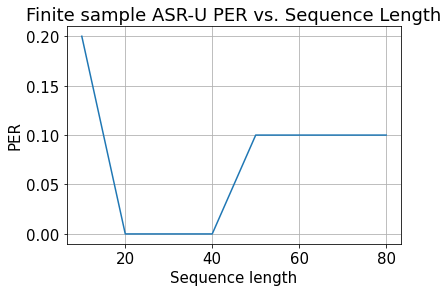

In [ ]:
# Plot PER vs sequence lengths using seaborn
df = pd.DataFrame(data_dict)
fig, ax = plt.subplots()
sns.lineplot(
    data=df,
    x="Sequence length",
    y="PER",
    markers=True,
    dashes=False,
)
plt.grid()
plt.title(r"Finite sample ASR-U PER vs. Sequence Length")

### 4. Disjoint union of cycles

Acoustic feature codebook size: 10
N-gram size: 2
Least singular value of P_X:  1.8234399381687993e-17


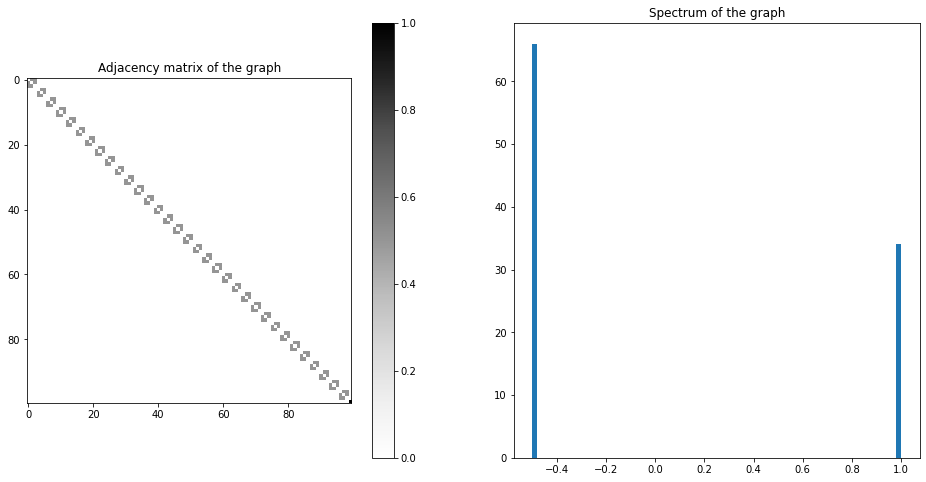

In [ ]:
# Create a union of cycles
n_x = n_y = 10  # codebook size of the acoustic features
n = 2  # n-gram size
l = 10
N_x = 2560
N_y = 2560
print(
    f"Acoustic feature codebook size: {n_x}\n"
    f"N-gram size: {n}" 
)
m = n_x**n  # number of n-grams
n_eigv = 2  # maximum number of eigenvalues

n_cycles = m // (2 * n_eigv - 1)
m_r = n_cycles * (2 * n_eigv - 1)
n_parts = n_cycles + m - m_r
sizes = [2 * n_eigv - 1 for i in range(n_cycles)]
sizes += [1]*(m-m_r)
A = make_disjoint_union(n_parts, sizes, "cycle")
Di = np.diag(1./A.sum(-1))
T = Di @ A
p_0 = make_initial_prob(n_x**n)
P_X, P_Y = make_asr_u_matrices(
    p_0, T, O_true, l, n,
)
s_min = sorted(np.linalg.svd(P_X)[1])[0]
print(
    "Least singular value of P_X: ",
    s_min,
)
O_true = np.eye(n_x)[np.random.permutation(n_x)]
plot_graph(T)

In [ ]:
random.seed(0)
np.random.seed(0)

N_x = 2560
N_y = 2560
n_trials = 1
n = 2  # n-gram size
n_x = n_y = 10  # Vocabulary size of the text
l = 40 # Utterance length
data_dict = {
    "Codebook size": [],
    r"Number of eigenvalues in $T$": [],
    "PER": [],
}
for i_trial in range(n_trials):
    for n_x in range(10, 11):
        m = n_x**n  # number of n-grams
        p_0 = make_initial_prob(m)
        n_eigv_list = list(range(2, 20, 2)) 
        for i, n_eigv in enumerate(n_eigv_list):
            # Create a union of cycles
            n_cycles = m // (2 * n_eigv - 1)
            m_r = n_cycles * (2 * n_eigv - 1)
            n_parts = n_cycles + m - m_r
            sizes = [2 * n_eigv - 1 for i in range(n_cycles)]
            sizes += [1]*(m-m_r)
            A = make_disjoint_union(n_parts, sizes, "cycle")
            Di = np.diag(1./A.sum(-1))
            T = Di @ A

            # Create matrices used in ASR-U
            O_true = np.eye(n_x)[np.random.permutation(n_x)]
            P_X, P_Y = make_asr_u_matrices(
                p_0, T, O_true, l, n,
            )

            # Sample sequences from the probability distribution
            X, Y = create_asr_u_dataset(
                p_0, T, O_true, n_x, n_y, n, l, N_x, N_y,
            )
            P_X_est = estimate_P_X(
                X, n_x, n, l, 
            )
            P_Y_est = estimate_P_Y(
                Y, n_y, n, l,
            )
            E_X = np.abs((P_X - P_X_est) @ O_true)
            E_Y = np.abs(P_Y - P_Y_est)
            s_min = sorted(np.linalg.svd(P_X)[1])[0]
            print(
                "Estimation error for P_X O: ", 
                np.linalg.norm(E_X, 2) / np.linalg.norm(P_X, 2),
            )
            print(
                "Estimation error for P_Y: ", 
                np.linalg.norm(E_Y, 2) / np.linalg.norm(P_Y, 2),
            )
            print(
                "Least singular value of P_X: ",
                s_min,
            )
            print(
                "Upper bound on assignment matrix error: ",
                (np.linalg.norm(E_X, 2) + np.linalg.norm(E_Y, 2)) / (s_min * n_x)
            )

            # Least-square solution of the matrix equation
            O_pred = exact_asr_u(P_X_est, P_Y_est)
            data_dict[r"Codebook size"].append(r"$|\mathcal{X}|=$"+str(n_x))
            data_dict[r"Number of eigenvalues in $T$"].append(n_eigv)
            per = calc_per(O_pred, O_true)
            data_dict["PER"].append(per)

            # Save data
            """
            save_dir = f"/content/disjoint_cycles__nx_{n_x}_n_{n}_Nx_{N_x}_neigv_{n_eigv}/{i_trial}"
            save_asr_u_dataset(
                X, 
                O_true, 
                split_dict={
                    "train": [0, 2304],
                    "valid": [2304, 2560],
                    "all": [0, 2560],
                }, 
                save_dir=save_dir,
                err_rate=per,
            )
            """

Estimation error for P_X O:  0.04152746810084506
Estimation error for P_Y:  0.11565950717845117
Least singular value of P_X:  7.66561131241951e-17
Upper bound on assignment matrix error:  584667191223977.9
Estimation error for P_X O:  0.048877649360527055
Estimation error for P_Y:  0.12854946510285306
Least singular value of P_X:  7.893850555635529e-17
Upper bound on assignment matrix error:  639080580830613.4
Estimation error for P_X O:  0.04792180801047745
Estimation error for P_Y:  0.12155775071448383
Least singular value of P_X:  0.0011484653510583235
Upper bound on assignment matrix error:  41.97046837837632
Estimation error for P_X O:  0.04920848665208291
Estimation error for P_Y:  0.1276955706998932
Least singular value of P_X:  0.0023844382611550572
Upper bound on assignment matrix error:  21.12023444768973
Estimation error for P_X O:  0.0495025165618543
Estimation error for P_Y:  0.10785957028816938
Least singular value of P_X:  0.004246310300005405
Upper bound on assignment m

Text(0.5, 1.0, 'Finite sample ASR-U PER vs. num. of eigenvalues in $T$')

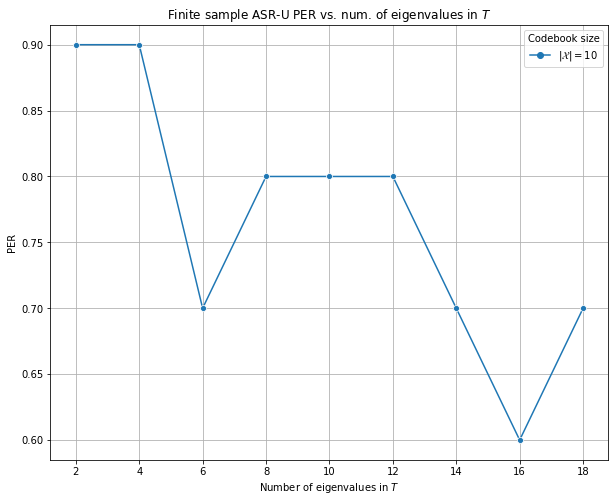

In [ ]:
# Plot PER vs num. of eigenvalues using seaborn
df = pd.DataFrame(data_dict)
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(
    data=df,
    x=r"Number of eigenvalues in $T$",
    y="PER",
    hue="Codebook size",
    style="Codebook size",
    markers=True,
    dashes=False,
)
plt.grid()
plt.title(r"Finite sample ASR-U PER vs. num. of eigenvalues in $T$")

[3 1 1 1 4 2 5 5 0 4]
[1 5 7 6 8 2 3 9 0 4]


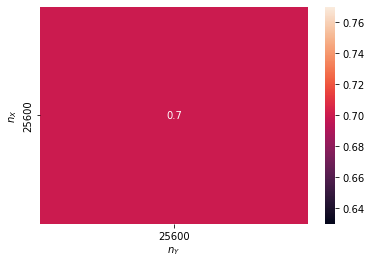

In [ ]:
n_trials = 1
data_dict = {
    r"$n_X$": [],
    r"$n_Y$": [],
    "PER": [],
} 
N = len(X)
for N_x in [25600]:
    for N_y in [25600]:
        avg_per = 0
        for _ in range(n_trials):
          x_idxs = np.random.permutation(N)[:N_x]
          y_idxs = np.random.permutation(N)[:N_y]
          P_X = estimate_P_X(X[x_idxs], n_x, l)
          P_Y = estimate_P_Y(Y[y_idxs], n_y, l)
          
          # Least-square solution of the matrix equation
          O_pred = exact_asr_u(P_X, P_Y)
          print(O_pred.argmax(-1))
          print(O_true.argmax(-1))
          avg_per += calc_per(O_pred, O_true)
        avg_per /= n_trials
        data_dict[r"$n_X$"].append(N_x)
        data_dict[r"$n_Y$"].append(N_y)
        data_dict["PER"].append(avg_per)
df = pd.DataFrame(data_dict)
df = df.pivot(r"$n_X$", r"$n_Y$", "PER")
sns.heatmap(df, annot=True)

### 5. Directed cycle

In [ ]:
# Create a union of cycles
n_x = n_y = 10  # codebook size of the acoustic features
n = 1  # n-gram size
l = 10
N_x = 1600
N_y = 10
print(
    f"Acoustic feature codebook size: {n_x}\n"
    f"N-gram size: {n}" 
)
m = n_x**n  # number of n-grams
T = np.eye(m)[list(range(1, m))+[0]]
p_0 = make_initial_prob(m)
O_true = np.eye(n_x)[list(range(1, m))+[0]]

X, _ = create_asr_u_dataset(
    p_0, 
    T, 
    O_true, 
    n_x, 
    n_y, 
    n, 
    l, 
    N_x, 
    N_y,
)
print(X.shape)
X = np.concatenate(
    [X] + [
        np.concatenate(
            [np.arange(i, m),
             np.arange(i)],
        )[..., np.newaxis]
        for i in range(m)
    ]
)
print(X.shape)
T_est = estimate_T(X, n_x, n)
plot_graph(T_est)

Acoustic feature codebook size: 10
N-gram size: 1
(1600, 10, 1)


ValueError: ignored

In [ ]:
save_dir = "/content/directed_cycle_10_1600"
save_asr_u_dataset(
    X, 
    O_true, 
    split_dict={
        "train": [0, 1600],
        "valid": [1600, 1610],
        "all": [0, 1610],
    }, 
    save_dir=save_dir,
)
make_archive(save_dir, save_dir+".zip")

### 6. Weighted De Bruijn graph

#### 6.1 Visualize the graph

Smallest singular value of P_X:  4.716122127892479e-33
Smallest singular value of P_X:  0.009141385927593983
Smallest singular value of P_X:  0.11414953579108769
Smallest singular value of P_X:  0.3333005695609003
Smallest singular value of P_X:  0.6182882372632693
Smallest singular value of P_X:  0.9498485168773856


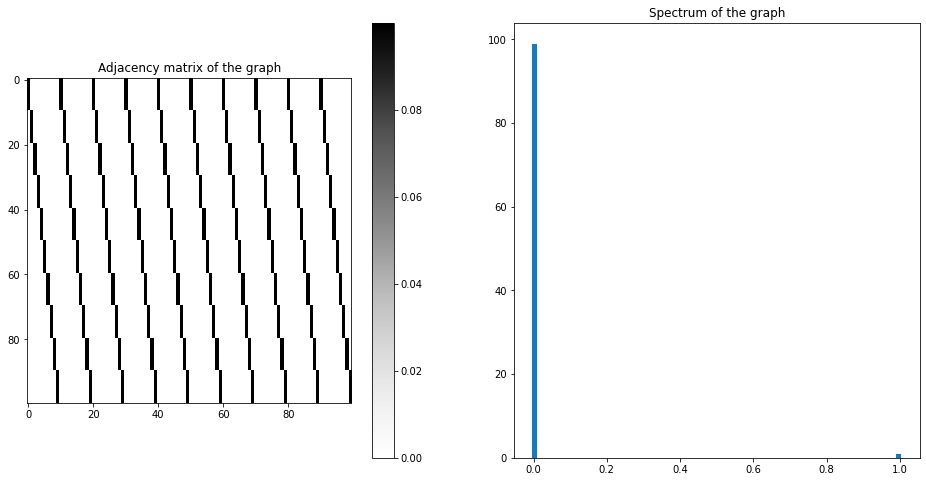

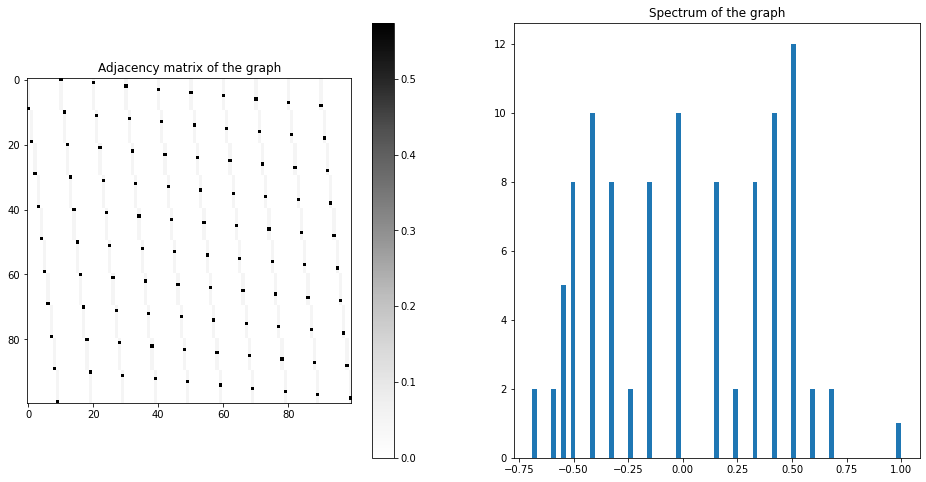

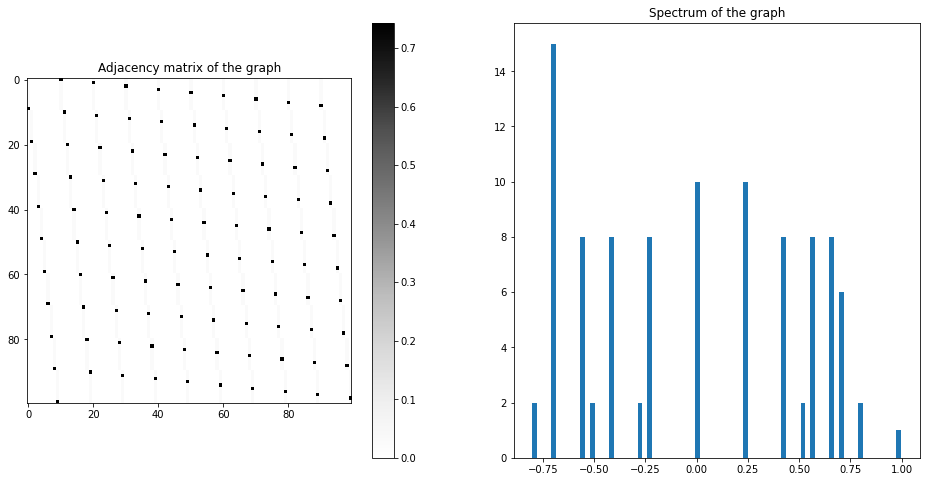

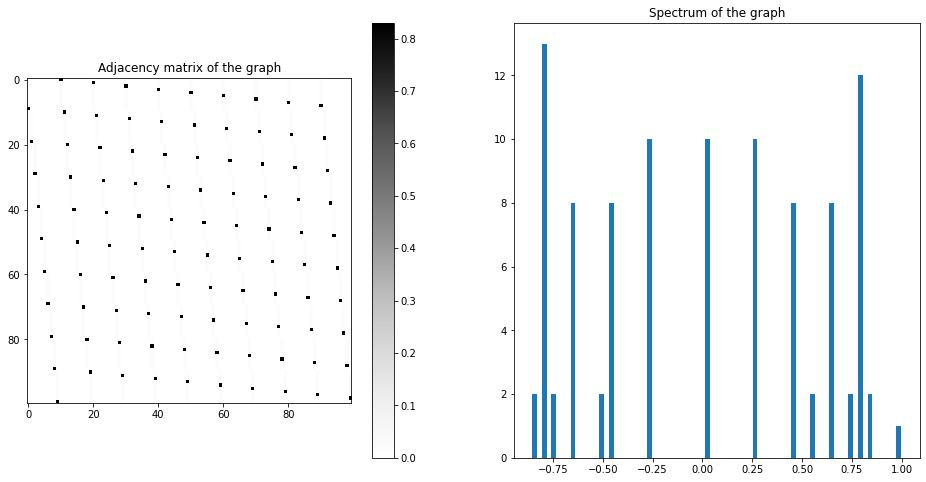

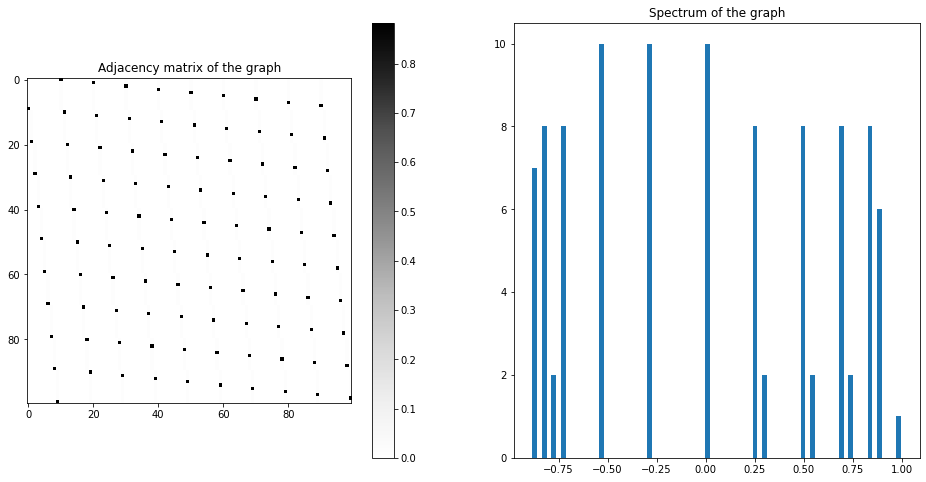

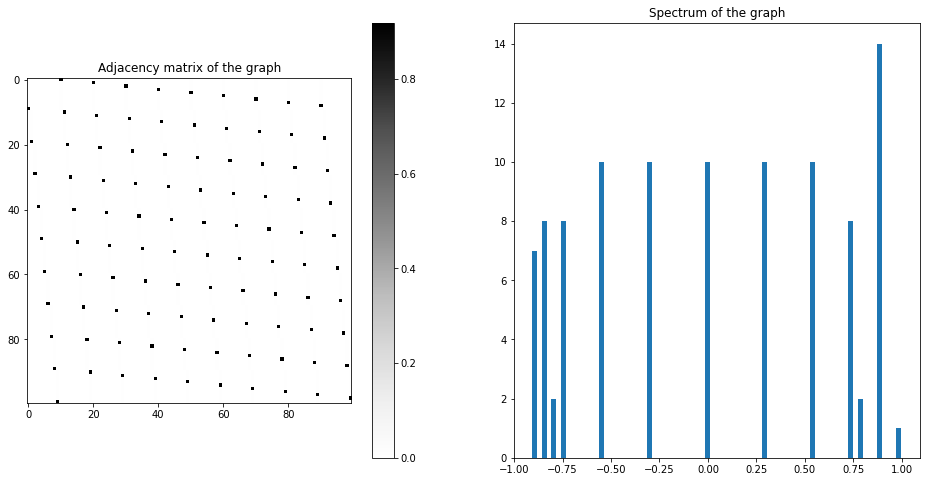

In [ ]:
# Create a De Bruijn graphs
n_x = n_y = 10  # codebook sizes
n = 2  # n-gram size
m = n_x**n
l = 100  # Sentence size
N_x = 2560
N_y = 2560

O_true = np.eye(n_x)[np.random.permutation(n_x)]
for w in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    weights = w * np.eye(m)[1] + (1 - w) * np.ones(m) / m
    A = make_debruijn(n, n_x, weights=weights)
    Di = np.diag(1./(A.sum(-1)+1e-10))
    T = Di @ A
    p_0 = np.eye(m)[0]
    P_X, P_Y = make_asr_u_matrices(
        p_0, T, O_true, l, n,
    )
    s_min = sorted(np.linalg.svd(P_X)[1])[0]
    print(
        "Smallest singular value of P_X: ",
        s_min,
    )
    plot_graph(T)

#### 6.2 PER vs smallest singular value

In [ ]:
random.seed(0)
np.random.seed(0)

N_x = 2560
N_y = 2560
n_trials = 1

n_x = n_y = 10  # Vocabulary size of the text
n = 2  # n-gram size
l = 40 # Utterance length
data_dict = {
    "Codebook size": [],
    r"$\sigma_{\min}(P^X)$": [],
    "PER": [],
}
for n_x in range(10, 11):
    n_y = n_x
    m = n_x**n  # number of n-grams
    # Create matrices used in ASR-U
    p_0 = np.eye(m)[0]
    O_true = np.eye(n_x)[np.random.permutation(n_x)]
    for i_w, w in enumerate(np.linspace(0, 1.0, 10)):
        weights = w * np.eye(m)[1] + (1 - w) * np.ones(m) / n_x #w * np.eye(n_x)[1] + (1 - w) * np.ones(n_x) / n_x
        A = make_debruijn(n, n_x, weights=weights)
        Di = np.diag(1./(A.sum(-1)+1e-10))
        T = Di @ A
        
        # Sample sequences from the probability distribution
        X, Y = create_asr_u_dataset(
            p_0, T, O_true, n_x, n_y, n, l, N_x, N_y,
        )
        T_est = estimate_T(
            X, n_x, n,
        )
        P_X_est = estimate_P_X(
            X, n_x, n, l,
        )
        P_Y_est = estimate_P_Y(
            Y, n_y, n, l,
        )
        P_X, P_Y = make_asr_u_matrices(
            p_0, T, O_true, l, n,
        )
        E_X = np.abs((P_X - P_X_est) @ O_true)
        E_Y = P_Y - P_Y_est
        s_min = sorted(np.linalg.svd(P_X)[1])[0]
        E_Y_minus_E_X = np.linalg.norm(E_Y - E_X, 2) 
        s_min_thres = 2 * E_Y_minus_E_X
        per_upper_bound = E_Y_minus_E_X / (s_min * n_x)
        
        print(
            "Estimation error for P_X O: ", 
            np.linalg.norm(E_X, 2), #/ np.linalg.norm(P_X, 2),
        )
        print(
            "Estimation error for P_Y: ", 
            np.linalg.norm(E_Y, 2), #/ np.linalg.norm(P_Y, 2),
        )
        print(
            "Least singular value of P_X: ",
            s_min,
        )
        print(
            "Phase transition threshold: ",
            s_min_thres,
        )
        print(
            "Upper bound on assignment matrix error: ",
            per_upper_bound,
        )

        # Least-square solution of the matrix equation
        O_pred = exact_asr_u(P_X_est, P_Y_est)
        data_dict[r"Codebook size"].append(r"$|\mathcal{X}|=$"+str(n_x))
        data_dict[r"$\sigma_{\min}(P^X)$"].append(s_min)
        per = calc_per(O_pred, O_true)
        print(
            "Actual PER: ",
            per,
        )
        data_dict["PER"].append(per)
        
        # Save data
        save_dir = f"/content/phase_transition_debruijn/debruijn__nx_{n_x}_n_{n}_Nx_{N_x}_level_{i_w}"
        save_asr_u_dataset(
            X, 
            Y,
            O_true, 
            split_dict={
                "train": [0, 2304],
                "valid": [2304, 2560],
            }, 
            save_dir=save_dir,
            err_rate=per,
        )

Estimation error for P_X O:  0.1390598788735755
Estimation error for P_Y:  0.0804696062256535
Least singular value of P_X:  1.612947182441067e-49
Phase transition threshold:  0.2821171891328481
Upper bound on assignment matrix error:  8.745394523889066e+46
Actual PER:  0.9
Estimation error for P_X O:  0.1452513190567764
Estimation error for P_Y:  0.07478696944585361
Least singular value of P_X:  3.179736033900957e-08
Phase transition threshold:  0.2956727336886487
Upper bound on assignment matrix error:  464932.82860010257
Actual PER:  0.6
Estimation error for P_X O:  0.12835479030059016
Estimation error for P_Y:  0.08312800329290396
Least singular value of P_X:  8.295236385899901e-06
Phase transition threshold:  0.26142750302440654
Upper bound on assignment matrix error:  1575.7688561399916
Actual PER:  0.7
Estimation error for P_X O:  0.12852780638262204
Estimation error for P_Y:  0.07705070456094033
Least singular value of P_X:  0.0002185084453811062
Phase transition threshold:  0.2

In [ ]:
# Plot PER vs num. of eigenvalues using seaborn
df = pd.DataFrame(data_dict)
fig, ax = plt.subplots()
sns.lineplot(
    data=df,
    x=r"$\sigma_{\min}(P^X)$",
    y="PER",
    hue="Codebook size",
    style="Codebook size",
    markers=True,
    dashes=False,
)
plt.grid()
ax.set_xscale("log")
plt.title(r"Finite sample ASR-U PER vs. num. of eigenvalues in $T$")

In [ ]:
# Zip all the files
save_dir = f"/content/phase_transition_debruijn"
make_archive(save_dir, save_dir+".zip")

### 7. Weighted $n$-cube

In [ ]:
weights = [0.5, 0.1]
A = make_hypercube(3, weights=weights)
# Create a De Bruijn graphs
n_x = n_y = 8  # codebook sizes
n = 2  # n-gram size
m = n_x**n
l = 100  # Sentence size
N_x = 2560
N_y = 2560

O_true = np.eye(n_x)[np.random.permutation(n_x)]
for i_w, w in enumerate(np.linspace(0.97, 1.0, 10)):
    weights = [w, 1 - w]
    A = make_hypercube(6, weights=weights)
    Di = np.diag(1./(A.sum(-1)+1e-10))
    T = Di @ A
    p_0 = np.eye(m)[0]
    P_X, P_Y = make_asr_u_matrices(
        p_0, T, O_true, l, n,
    )
    s_min = sorted(np.linalg.svd(P_X)[1])[0]
    print(
        "Smallest singular value of P_X: ",
        s_min,
    )
    plot_graph(T)

[array([0, 0, 0]), array([0, 0, 1]), array([0, 1, 1]), array([1, 1, 1]), array([1, 0, 1]), array([1, 0, 0]), array([1, 1, 0]), array([0, 1, 0])]
[(0, 4), (4, 6), (6, 7), (7, 5), (5, 1), (1, 3), (3, 2), (2, 0)]


In [ ]:
random.seed(0)
np.random.seed(0)

N_x = 2560
N_y = 2560
n_trials = 1

n_x = n_y = 8  # Vocabulary size of the text
n = 2  # n-gram size
l = 80 # Utterance length
data_dict = {
    "Codebook size": [],
    r"$\sigma_{\min}(P^X)$": [],
    "PER": [],
}
for n_x in range(8, 9):
    n_y = n_x
    m = n_x**n  # number of n-grams
    # Create matrices used in ASR-U
    p_0 = np.eye(m)[0]
    O_true = np.eye(n_x)[np.random.permutation(n_x)]
    for i_w, w in enumerate(np.linspace(0.98, 1.0, 10)):
        print(f"weight={w}")
        weights = [w, 1 - w]
        A = make_hypercube(6, weights=weights)
        Di = np.diag(1./(A.sum(-1)+1e-10))
        T = Di @ A
        
        # Sample sequences from the probability distribution
        X, Y = create_asr_u_dataset(
            p_0, T, O_true, n_x, n_y, n, l, N_x, N_y,
        )
        T_est = estimate_T(
            X, n_x, n,
        )
        P_X_est = estimate_P_X(
            X, n_x, n, l,
        )
        P_Y_est = estimate_P_Y(
            Y, n_y, n, l,
        )
        P_X, P_Y = make_asr_u_matrices(
            p_0, T, O_true, l, n,
        )
        E_X = (P_X - P_X_est) @ O_true
        E_Y = P_Y - P_Y_est
        s_min = sorted(np.linalg.svd(P_X)[1])[0]
        E_Y_minus_E_X = np.linalg.norm(E_Y - E_X, 2)
        s_min_thres = 2 * E_Y_minus_E_X
        per_upper_bound = E_Y_minus_E_X / (s_min * n_x)
        print(
            "Estimation error for P_X O: ", 
            np.linalg.norm(E_X, 2), #/ np.linalg.norm(P_X, 2),
        )
        print(
            "Estimation error for P_Y: ", 
            np.linalg.norm(E_Y, 2), #/ np.linalg.norm(P_Y, 2),
        )
        print(
            "Least singular value of P_X: ",
            s_min,
        )
        print(
            "Phase transition threshold: ",
            s_min_thres,
        )
        print(
            "Upper bound on assignment matrix error: ",
            per_upper_bound,
        )

        # Least-square solution of the matrix equation
        O_pred = exact_asr_u(P_X_est, P_Y_est)
        data_dict[r"Codebook size"].append(r"$|\mathcal{X}|=$"+str(n_x))
        data_dict[r"$\sigma_{\min}(P^X)$"].append(s_min)
        per = calc_per(O_pred, O_true)
        print(
            "Actual PER: ",
            per,
        )
        data_dict["PER"].append(per)
        
        # Save data
        save_dir = f"/content/phase_transition_hypercube/hypercube__nx_{n_x}_n_{n}_Nx_{N_x}_level_{i_w}"
        save_asr_u_dataset(
            X, 
            Y,
            O_true, 
            split_dict={
                "train": [0, 2304],
                "valid": [2304, 2560],
            }, 
            save_dir=save_dir,
            err_rate=per,
        )

weight=0.98
Estimation error for P_X O:  0.10770626751572542
Estimation error for P_Y:  0.09599275651576915
Least singular value of P_X:  0.00037441340422024314
Phase transition threshold:  0.302373764180646
Upper bound on assignment matrix error:  50.47458250232327
Actual PER:  0.5
weight=0.9822222222222222
Estimation error for P_X O:  0.1039193601583683
Estimation error for P_Y:  0.10613222631273718
Least singular value of P_X:  0.0007011989366029938
Phase transition threshold:  0.2948397716529598
Upper bound on assignment matrix error:  26.279968160795
Actual PER:  0.5
weight=0.9844444444444445
Estimation error for P_X O:  0.10315853553269991
Estimation error for P_Y:  0.10173338468904482
Least singular value of P_X:  0.001370119517360781
Phase transition threshold:  0.28277997779839603
Upper bound on assignment matrix error:  12.899421100462934
Actual PER:  0.5
weight=0.9866666666666667
Estimation error for P_X O:  0.10931468839421668
Estimation error for P_Y:  0.10049464438205111


Text(0.5, 1.0, 'Finite sample ASR-U PER vs. num. of eigenvalues in $T$')

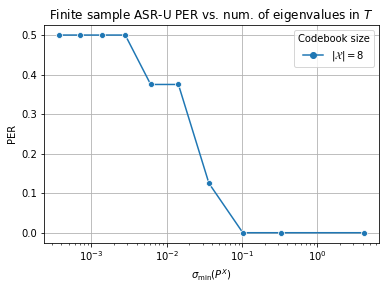

In [ ]:
# Plot PER vs num. of eigenvalues using seaborn
df = pd.DataFrame(data_dict)
fig, ax = plt.subplots()
sns.lineplot(
    data=df,
    x=r"$\sigma_{\min}(P^X)$",
    y="PER",
    hue="Codebook size",
    style="Codebook size",
    markers=True,
    dashes=False,
)
plt.grid()
ax.set_xscale("log")
plt.title(r"Finite sample ASR-U PER vs. num. of eigenvalues in $T$")

In [ ]:
# Zip all the files
save_dir = f"/content/phase_transition_hypercube"
make_archive(save_dir, save_dir+".zip")

# GAN-based ASR-U on various Markov graphs

In [ ]:
# Load pandas DataFrame from CSV file
csv_file = "phase_transition.csv"
df = pd.read_csv(csv_file)
print(df)

    GAN Type          Graph Type  $\sigma_{\min}(P^X)$  $\sigma_{\min}^*$  \
0       MMD            Circulant              0.472000            0.35600   
1       MMD            Circulant              0.021800            0.38400   
2       MMD            Circulant              0.003120            0.38500   
3       MMD            Circulant              0.001710            0.38800   
4       MMD            Circulant              0.000207            0.41500   
..       ...                 ...                   ...                ...   
125       LS  Weighted De Bruijn              0.014100            0.26200   
126       LS  Weighted hypercube              0.000374            0.30000   
127       LS  Weighted hypercube              0.000701            0.29484   
128       LS  Weighted hypercube              0.001370            0.28278   
129       LS  Weighted hypercube              0.002810            0.31736   

     Final Loss  Final PER  
0         0.604     0.0000  
1         0.057  

## 1 Circulant graph 

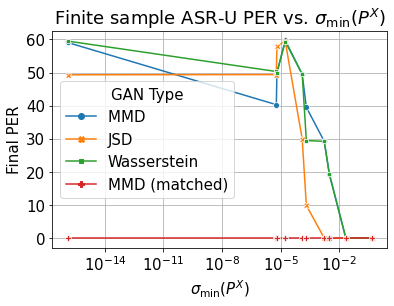

In [ ]:
# Plot PER vs num. of eigenvalues using seaborn
# Phase transition threshold: 0.39
df1 = df[df["Graph Type"]=="Circulant"]
df1 = df1[df1["GAN Type"]!="LS"]

fig, ax = plt.subplots()
sns.lineplot(
    data=df1,
    x=r"$\sigma_{\min}(P^X)$",
    y="Final PER",
    hue="GAN Type",
    style="GAN Type",
    markers=True,
    dashes=False,
)
plt.grid()
ax.set_xscale("log")
plt.title(r"Finite sample ASR-U PER vs. $\sigma_\min(P^X)$")
plt.savefig("circulant_per_vs_sigma_min")

## 2 Weighted De Bruijn Graph

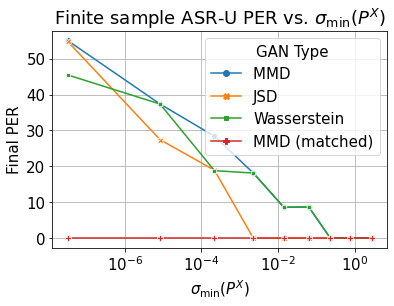

In [ ]:
# Plot PER vs num. of eigenvalues using seaborn
# Phase transition threshold: 0.27 
df2 = df[df["Graph Type"]=="Weighted De Bruijn"]
df2 = df2[df2["GAN Type"]!="LS"]

fig, ax = plt.subplots()
sns.lineplot(
    data=df2,
    x=r"$\sigma_{\min}(P^X)$",
    y="Final PER",
    hue="GAN Type",
    style="GAN Type",
    markers=True,
    dashes=False,
)
plt.grid()
ax.set_xscale("log")
plt.title(r"Finite sample ASR-U PER vs. $\sigma_\min(P^X)$")
plt.savefig("debruijn_per_vs_sigma_min")

## 3 Weighted $n$-cube

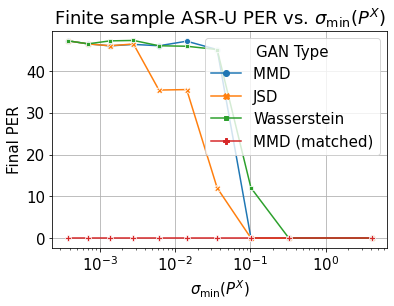

In [ ]:
# Plot PER vs num. of eigenvalues using seaborn
df3 = df[df["Graph Type"]=="Weighted hypercube"]
df3 = df3[df3["GAN Type"]!="LS"]

fig, ax = plt.subplots()
sns.lineplot(
    data=df3,
    x=r"$\sigma_{\min}(P^X)$",
    y="Final PER",
    hue="GAN Type",
    style="GAN Type",
    markers=True,
    dashes=False,
)
plt.grid()
ax.set_xscale("log")
plt.title(r"Finite sample ASR-U PER vs. $\sigma_\min(P^X)$")
plt.savefig("hypercube_per_vs_sigma_min")

In [ ]:
# Load pandas DataFrame from CSV file
csv_file = "effect_of_reset.csv"
df = pd.read_csv(csv_file)
print(df)

              Model GAN type Reset Graph Type  $\sigma_{\min}(P^X)$  Final PER
0               MMD      MMD   Yes  Circulant          4.720000e-01     0.0000
1               MMD      MMD   Yes  Circulant          2.180000e-02     0.0000
2               MMD      MMD   Yes  Circulant          3.120000e-03    19.3457
3               MMD      MMD   Yes  Circulant          1.710000e-03    29.2188
4               MMD      MMD   Yes  Circulant          2.070000e-04    39.4995
5               MMD      MMD   Yes  Circulant          1.270000e-04    49.4873
6               MMD      MMD   Yes  Circulant          1.220000e-16    59.0723
7               MMD      MMD   Yes  Circulant          1.720000e-05    59.6802
8               MMD      MMD   Yes  Circulant          6.010000e-06    40.2881
9               MMD      MMD   Yes  Circulant          6.450000e-06    49.9585
10    MMD w/o reset      MMD    No  Circulant          4.720000e-01     0.0000
11    MMD w/o reset      MMD    No  Circulant       

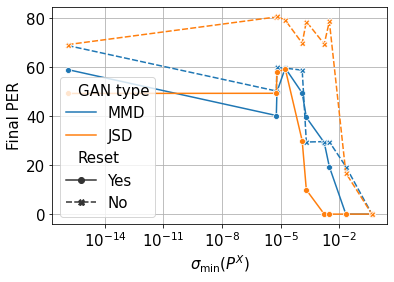

In [ ]:
# Plot Effect of reset using seaborn
fig, ax = plt.subplots()
sns.lineplot(
    data=df,
    x=r"$\sigma_{\min}(P^X)$",
    y="Final PER",
    hue="GAN type",
    style="Reset",
    markers=True,
    dashes=True,
)
plt.grid()
ax.set_xscale("log")
plt.savefig("effect_of_reset")

In [ ]:
# Load pandas DataFrame from CSV file
csv_file = "effect_of_averaging_strategy.csv"
df = pd.read_csv(csv_file)
print(df)

   GAN type Averaging type Graph Type  $\sigma_{\min}(P^X)$  Final PER
0       JSD     soft input  Circulant          4.720000e-01     0.0000
1       JSD     soft input  Circulant          2.180000e-02     0.0000
2       JSD     soft input  Circulant          3.120000e-03     0.0000
3       JSD     soft input  Circulant          1.710000e-03     0.0000
4       JSD     soft input  Circulant          2.070000e-04     9.8950
..      ...            ...        ...                   ...        ...
75      JSD         Gumbel  Circulant          1.270000e-04    29.3750
76      JSD         Gumbel  Circulant          1.220000e-16    29.7827
77      JSD         Gumbel  Circulant          1.720000e-05    10.0220
78      JSD         Gumbel  Circulant          6.010000e-06    49.6606
79      JSD         Gumbel  Circulant          6.450000e-06    48.6938

[80 rows x 5 columns]


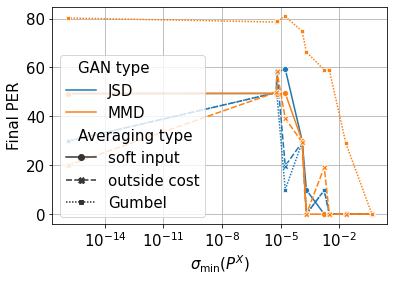

In [ ]:
# Plot effect of averaging strategy using seaborn
fig, ax = plt.subplots()
sns.lineplot(
    data=df[df["Averaging type"]!="inside cost"],
    x=r"$\sigma_{\min}(P^X)$",
    y="Final PER",
    hue="GAN type",
    style="Averaging type",
    markers=True,
    dashes=True,
)
plt.grid()
ax.set_xscale("log")
plt.savefig("effect_of_avg")